In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, ydata_profiling, shap

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df= pd.read_csv('./data/cardata.csv', index_col=0)

EDA

In [4]:
summary = df.describe()

In [5]:
summary.drop(['nrOfPictures','postalCode'],axis=1,inplace=True)

In [6]:
summary

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000


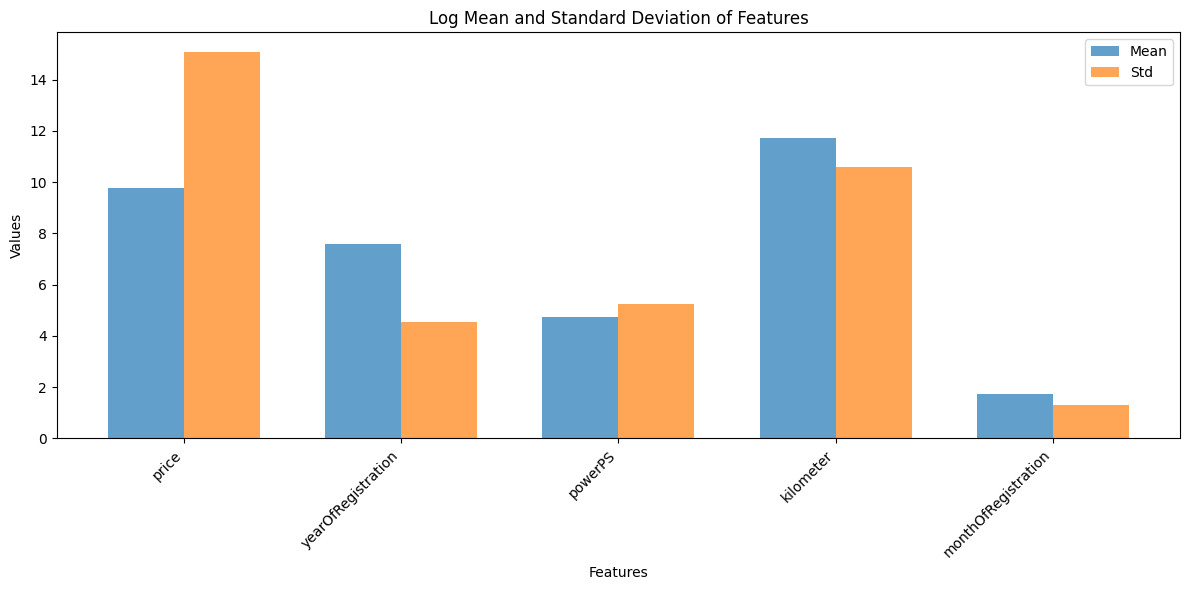

In [7]:
x_labels = list(summary.columns)
y1 = np.log(list(summary.loc['mean']))
y2 = np.log(list(list(summary.loc['std'])))

width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(12,6))

plt.bar(x - width/2, y1, width=width, label='Mean', alpha=0.7)
plt.bar(x + width/2, y2, width=width, label='Std', alpha=0.7)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Log Mean and Standard Deviation of Features')
plt.legend()

plt.tight_layout()
plt.show()

**Note:**  
- `powerPS`, `yearOfRegistration`, and `monthOfRegistration` exhibit very little variation (low standard deviation). Further investigation will be conducted.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-null  o

In [9]:
# Missing Values
dataInfo =[]
for col in df.columns:
  num_nam = df[col].isna().sum()
  dataInfo.append([col,num_nam,num_nam/len(df)*100,df[col].nunique()])

In [10]:
mising_value_df = pd.DataFrame(dataInfo,columns=['Feature','NumNan','PercentNan','NumUnique'])

In [11]:
mising_value_df

,Feature,NumNan,PercentNan,NumUnique
0,dateCrawled,0,0.000000,280500
1,name,0,0.000000,233531
2,seller,0,0.000000,2
3,offerType,0,0.000000,2
4,price,0,0.000000,5597
5,abtest,0,0.000000,2
6,vehicleType,37869,10.192771,8
7,yearOfRegistration,0,0.000000,155
8,gearbox,20209,5.439429,2
9,powerPS,0,0.000000,794


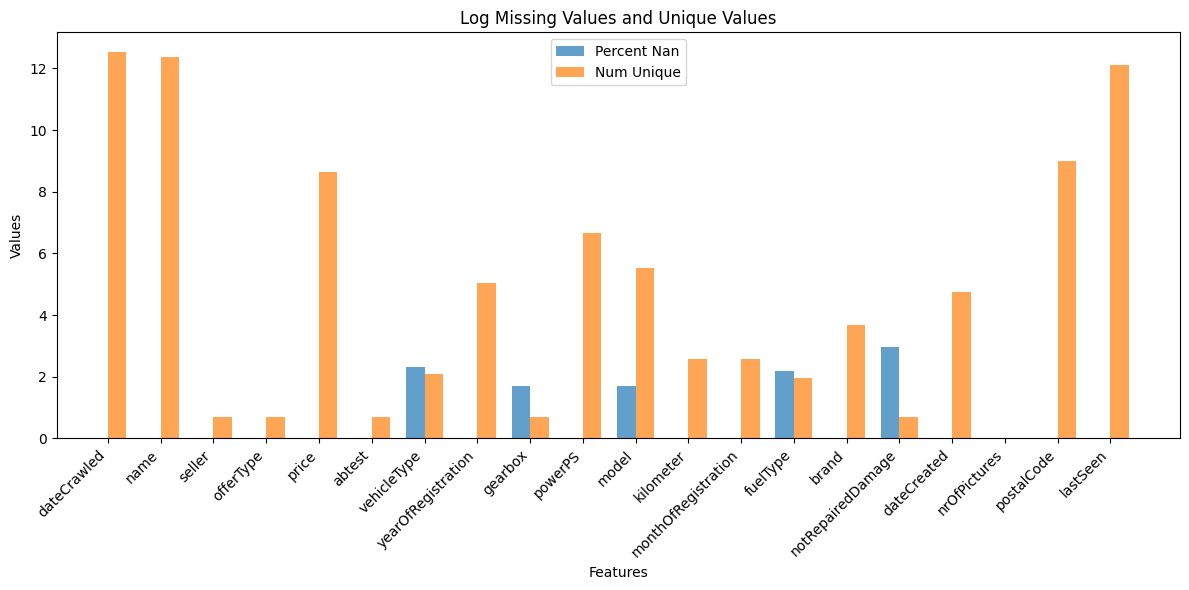

In [12]:
x_labels = list(mising_value_df['Feature'])
y1 = np.log(list(mising_value_df['PercentNan']))
y2 = np.log(list(mising_value_df['NumUnique']))

width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(12,6))

plt.bar(x - width/2, y1, width=width, label='Percent Nan', alpha=0.7)
plt.bar(x + width/2, y2, width=width, label='Num Unique', alpha=0.7)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Log Missing Values and Unique Values')
plt.legend()

plt.tight_layout()
plt.show()

**Note:**

- `nrOfPictures` has only one unique value and will be removed.
- `vehicleType` and `notRepairedDamage` have the highest number of missing values; these will require further investigation.


In [13]:
df.drop('nrOfPictures', axis=1, inplace=True)

In [14]:
# 4. German to English, as best as I can
df['gearbox'] = df['gearbox'].apply(lambda g: 'Manual' if g == 'manuell' else 'Automatic')
df['notRepairedDamage'] = df['notRepairedDamage'].apply(lambda g: 'Yes' if g == 'ja' else 'No' if g =='nein' else 'NaN')
df.loc[df['fuelType'] == 'benzin', 'fuelType'] = 'Petrol'
df.loc[df['fuelType'] == 'andere', 'fuelType'] = 'Other'

In [15]:
categorical_cols = ['seller','abtest','vehicleType','gearbox','fuelType','notRepairedDamage','offerType']
data = []
for col in categorical_cols:
  data.append(df[col].value_counts())

**Note:**

- `brand`, `model`, and `powerPS` have a large number of unique values; therefore, representing them with pie charts is not meaningful.


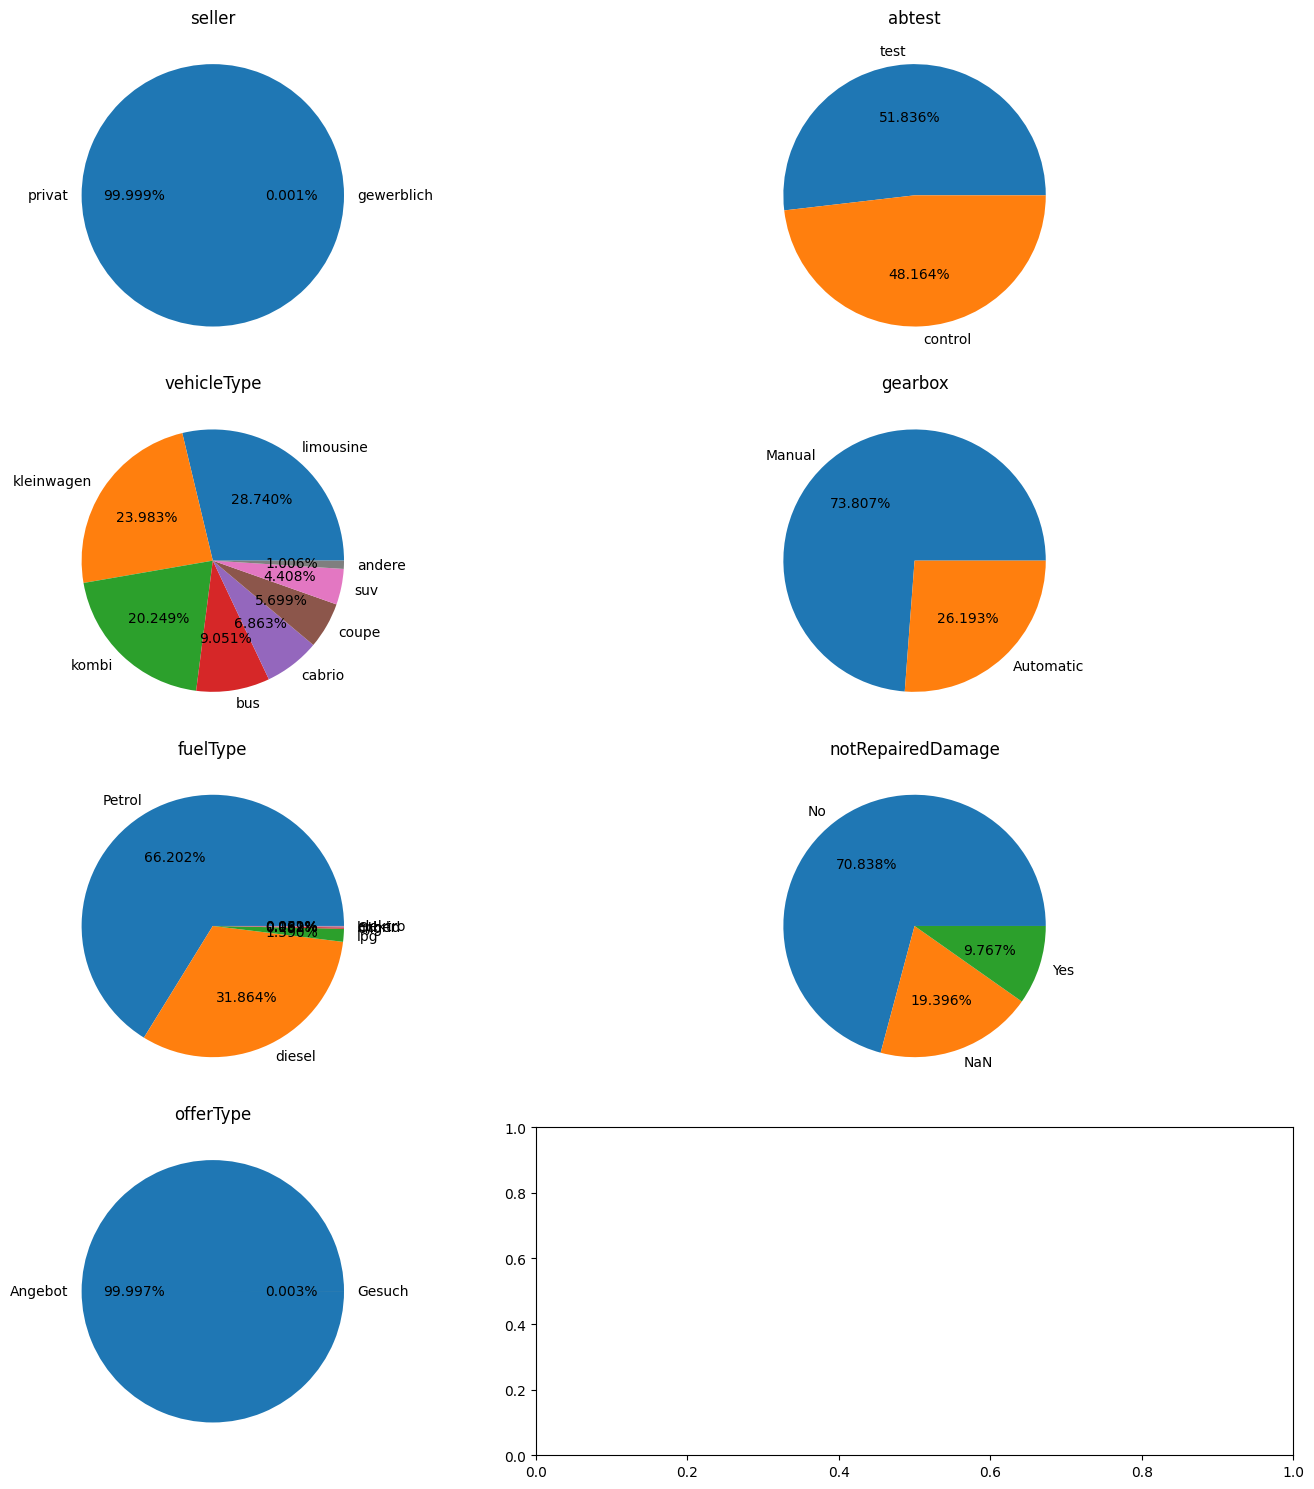

In [16]:
fig,ax = plt.subplots(4,2,figsize=(15,15))
axes = ax.flatten()
for i,col_data in enumerate(data):
  axes[i].pie(col_data,labels=col_data.index,autopct='%1.3f%%')
  axes[i].set_title(categorical_cols[i])
plt.tight_layout()
plt.show()

**Note:**

- `seller` and `offerType` each have only 2 unique values, with one value appearing in less than 0.003% of rows. These columns will be removed.
- Rows with rare `fuelType` values (`lpg`, `cng`, `hybrid`, `other`, and `elektro`) contribute very little to the dataset and will be dropped.
- `notRepairedDamage` contains 19.3% missing values; rows with missing entries in this column will be removed.


In [17]:
# Drop the 'seller', 'offerType' columns
df.drop('seller', axis=1, inplace=True)
df.drop('offerType', axis=1, inplace=True)


# Drop rows with feul type lpg, cng etc
df = df[(df['fuelType'] == 'Petrol') | (df['fuelType'] == 'Diesel')]

df.head()

,dateCrawled,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
index,,,,,,,,,,,,,,,,,
0,2016-03-24 11:52:17,Golf_3_1.6,480,test,NaN,1993,Manual,0,golf,150000,0,Petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,Manual,75,golf,150000,6,Petrol,volkswagen,No,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,Manual,102,3er,150000,10,Petrol,bmw,Yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,2200,test,cabrio,2004,Manual,109,2_reihe,150000,8,Petrol,peugeot,No,2016-04-01 00:00:00,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,VW_Derby_Bj_80__Scheunenfund,0,test,limousine,1980,Manual,50,andere,40000,7,Petrol,volkswagen,No,2016-03-21 00:00:00,19348,2016-03-25 16:47:58


**Note:**

- `lastSeen` and `dateCrawled` will be removed as they have no impact on the target variable (`price`).
- Rows with `yearOfRegistration` below 1980 or above 2025 will be dropped, as values outside this range are likely erroneous.


In [18]:
#  DateTime Conversion --> Drop 'dateCrawled' and 'lastSeen'
df.drop(['lastSeen', 'dateCrawled'], axis=1, inplace=True)
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
#  Define a range for the 'yearOfRegistration'
df = df[df['yearOfRegistration'].between(1980, 2025)]

In [19]:
df.head()

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode
index,,,,,,,,,,,,,,,
0,Golf_3_1.6,480,test,NaN,1993,Manual,0,golf,150000,0,Petrol,volkswagen,NaN,2016-03-24,70435
3,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,Manual,75,golf,150000,6,Petrol,volkswagen,No,2016-03-17,91074
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,Manual,102,3er,150000,10,Petrol,bmw,Yes,2016-04-04,33775
6,Peugeot_206_CC_110_Platinum,2200,test,cabrio,2004,Manual,109,2_reihe,150000,8,Petrol,peugeot,No,2016-04-01,67112
7,VW_Derby_Bj_80__Scheunenfund,0,test,limousine,1980,Manual,50,andere,40000,7,Petrol,volkswagen,No,2016-03-21,19348


### Count Analysis of `brand`

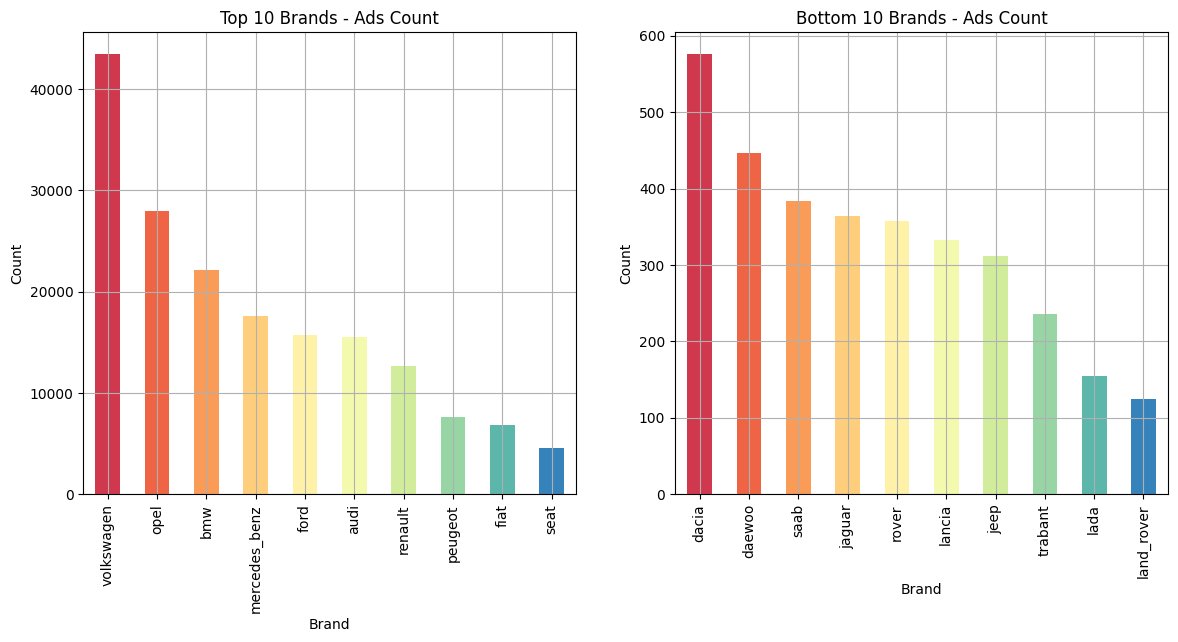

In [20]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['brand'].value_counts().head(10).plot(kind='bar', title='Top 10 Brands - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['brand'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Brands - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note:**

- There is a high degree of variance in the `brand` feature, indicating that the data is diverse and potentially valuable for analysis.


### Count analysis of models

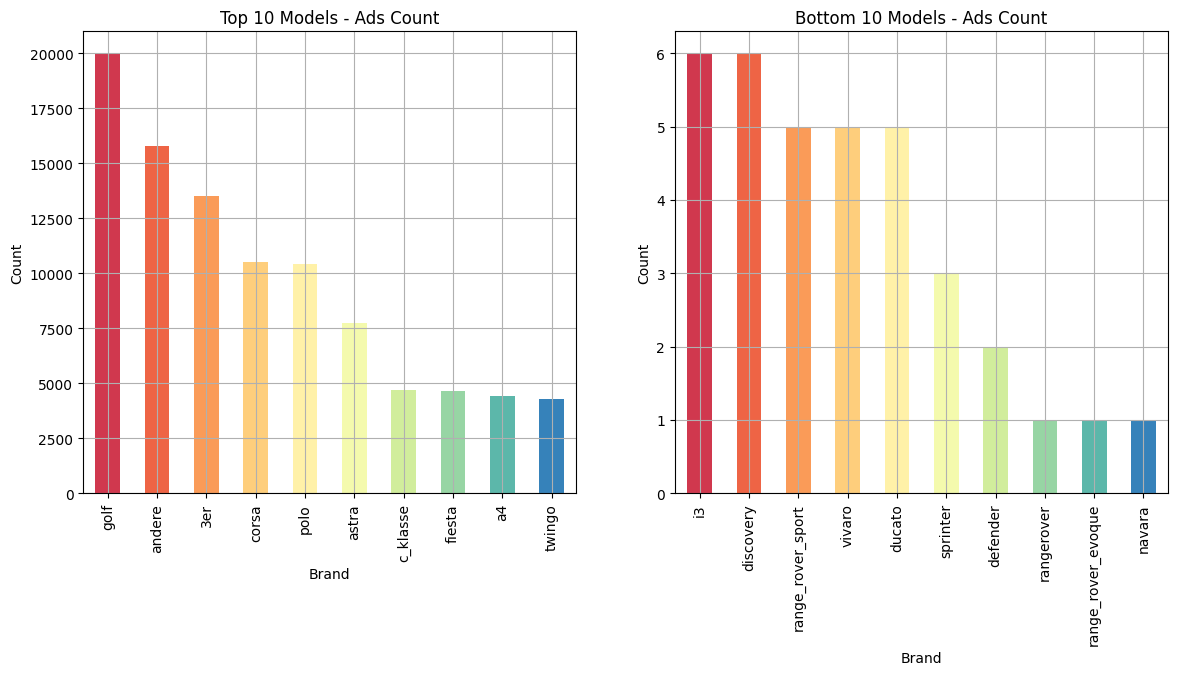

In [21]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['model'].value_counts().head(10).plot(kind='bar', title='Top 10 Models - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['model'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Models - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note** 
- Clearly lots of varaince. so data is useful

### Count analysis of Vechile type

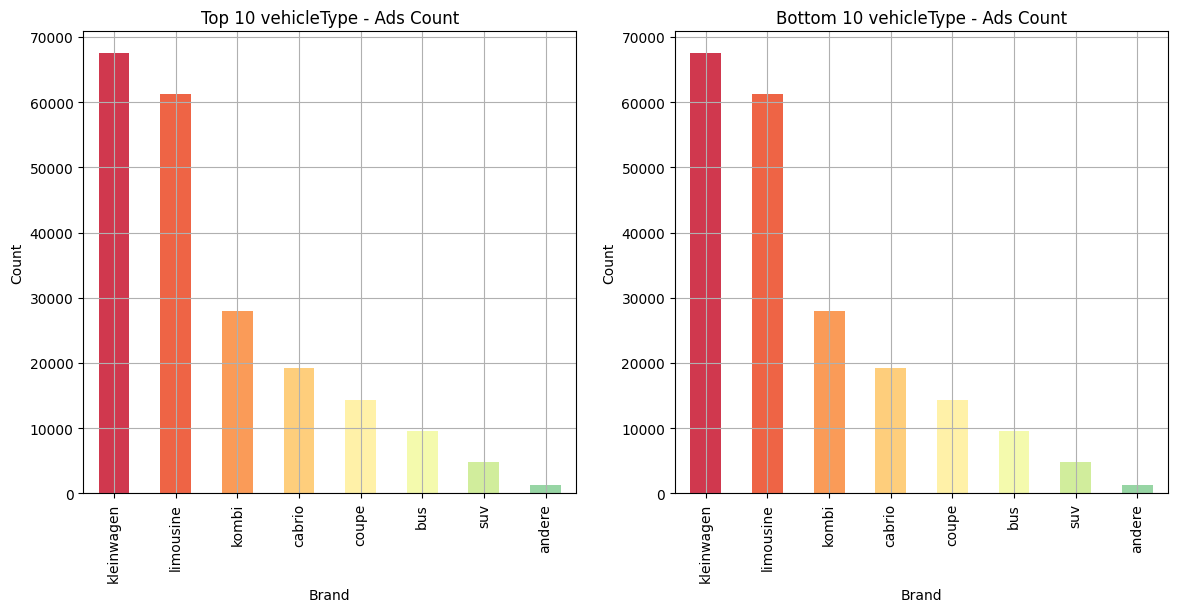

In [22]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['vehicleType'].value_counts().head(10).plot(kind='bar', title='Top 10 vehicleType - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['vehicleType'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 vehicleType - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note** 
- Clearly lots of varaince. so data is useful

### Comparative Analysis of `model` and `brand`

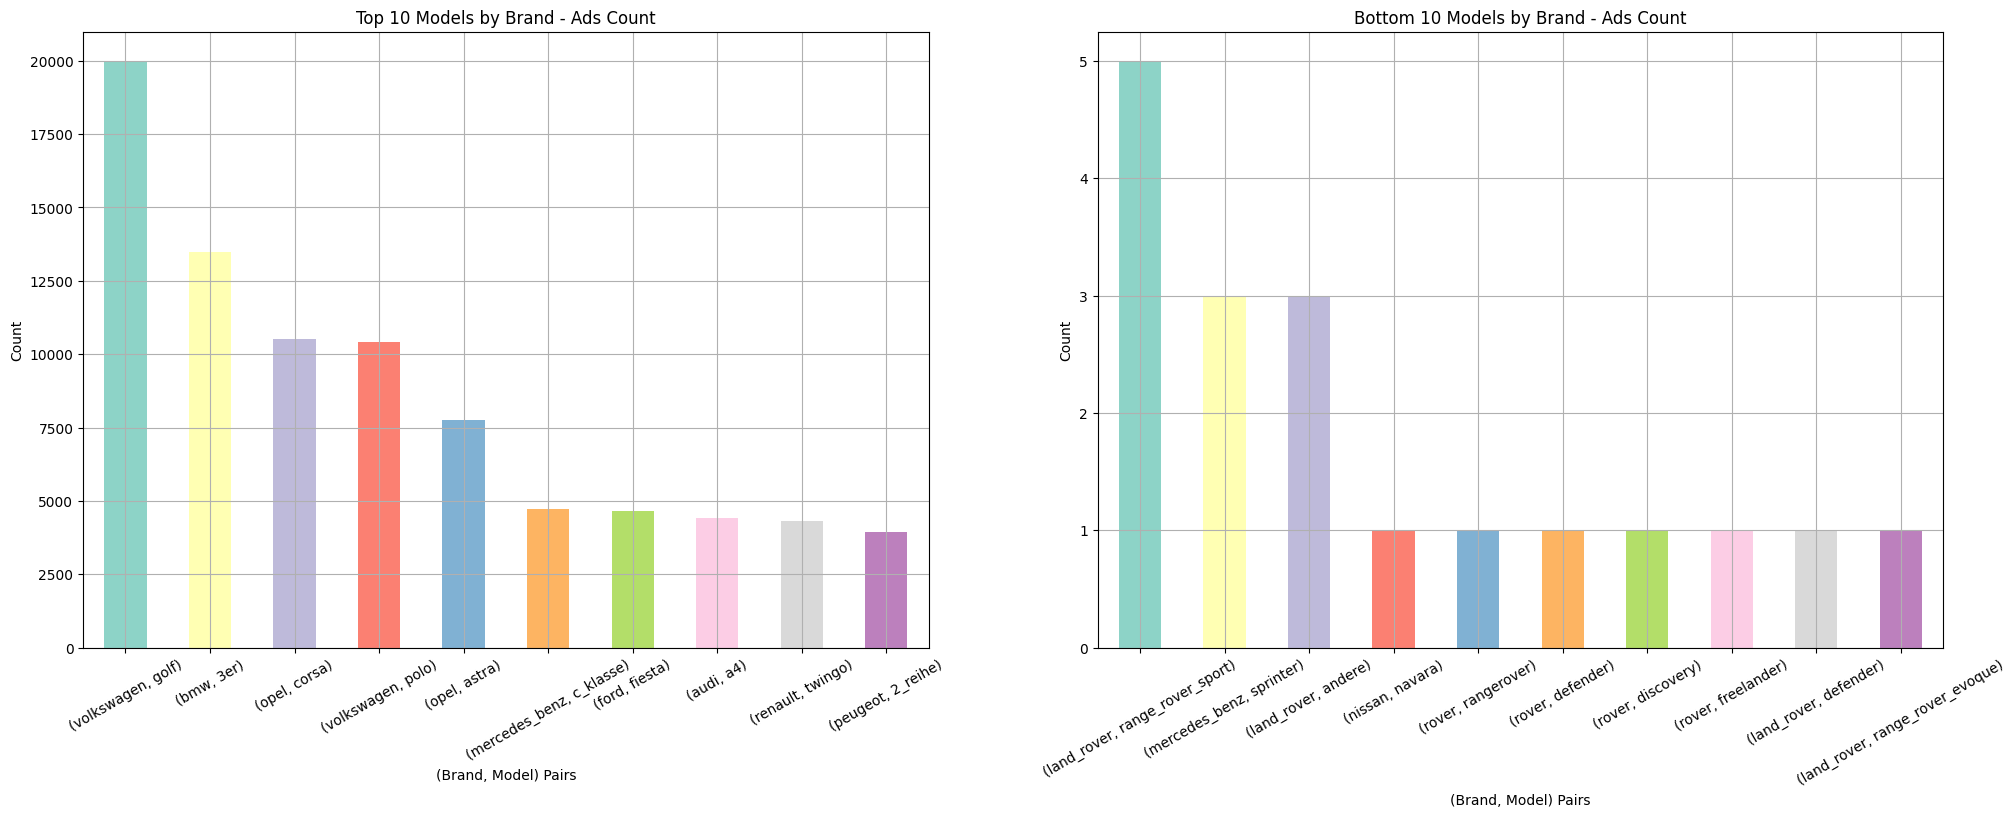

In [23]:
group_by_brand = df.groupby('brand')['model'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

group_by_brand.head(10).plot(kind='bar', grid=True, rot=30, xlabel="(Brand, Model) Pairs", ylabel='Count', title='Top 10 Models by Brand - Ads Count', ax=axes[0], color=colors_10_2)
group_by_brand.tail(10).plot(kind='bar', grid=True, rot=30, xlabel="(Brand, Model) Pairs", ylabel='Count', title='Bottom 10 Models by Brand - Ads Count', ax=axes[1], color=colors_10_2)
plt.show()

### Comparative Analysis of `vehicleType`, `brand`, and `model`

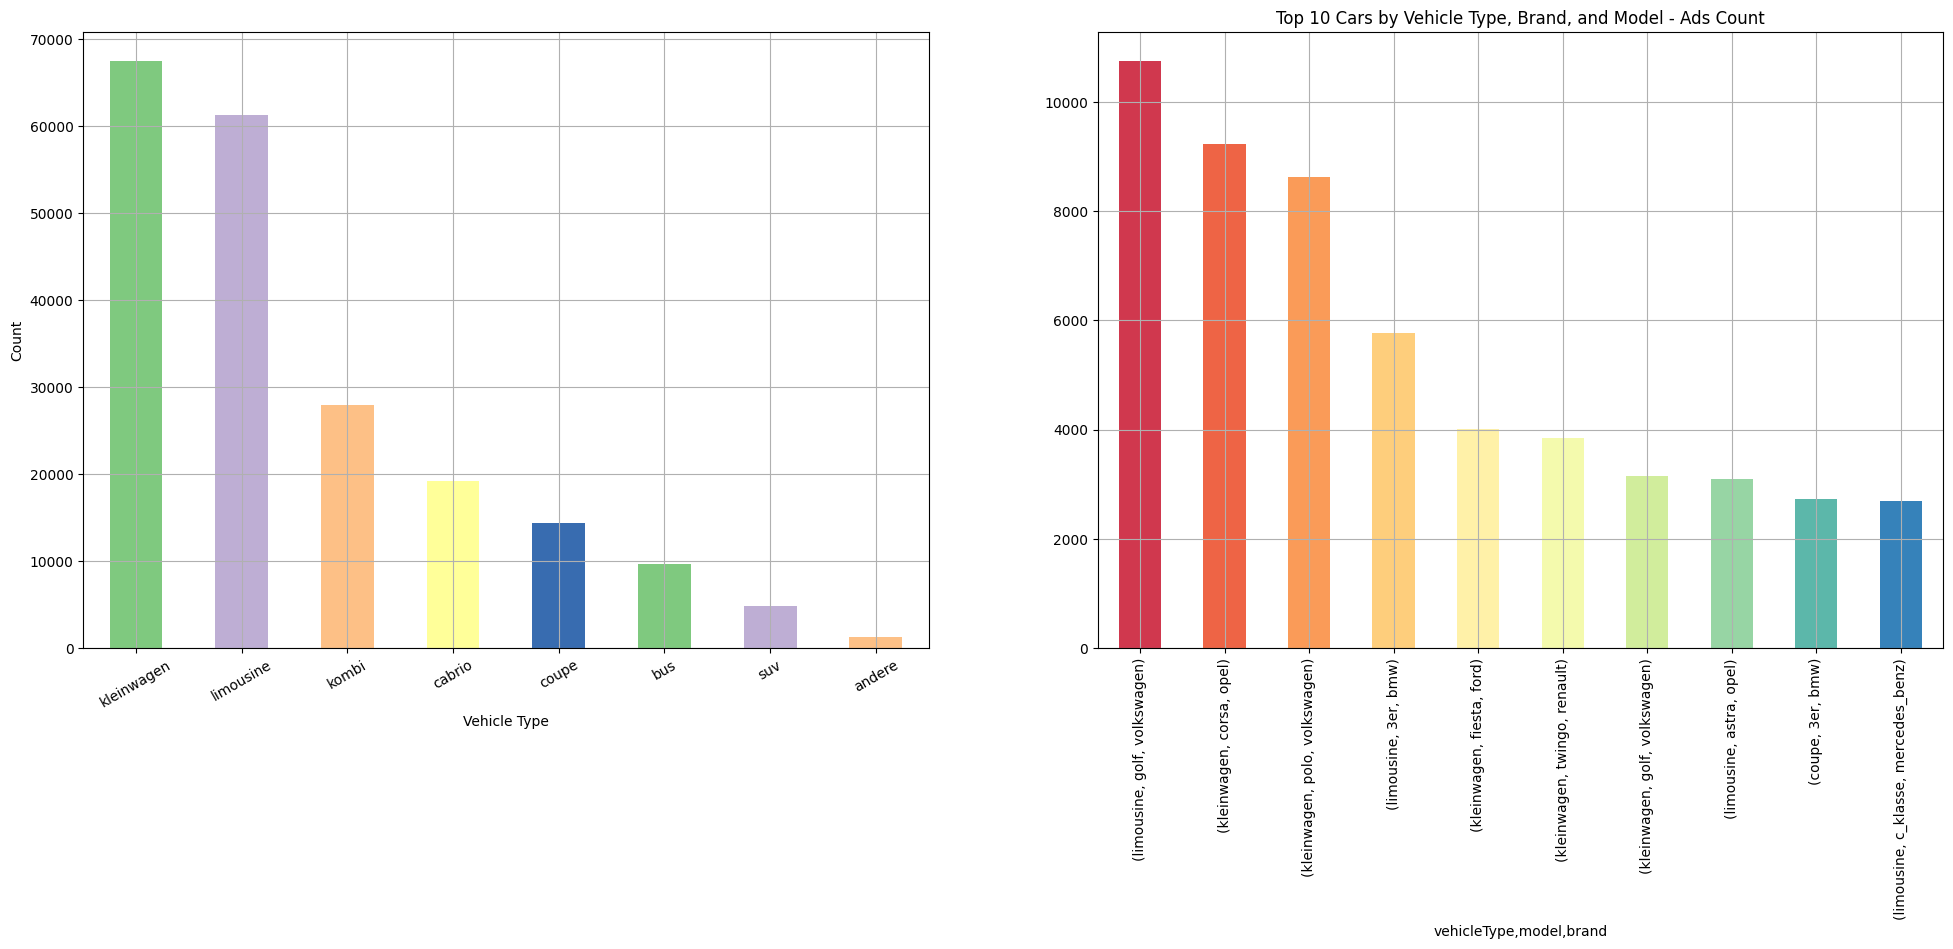

In [24]:
group_by_vehicle_type = df.groupby('vehicleType')[['model', 'brand']].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

df['vehicleType'].value_counts().plot(kind='bar', color=colors_5, ax=axes[0], grid=True, rot=30, xlabel='Vehicle Type', ylabel='Count', title='')
group_by_vehicle_type.head(10).plot(kind='bar', grid=True, color=colors_10_1, ax=axes[1], title='Top 10 Cars by Vehicle Type, Brand, and Model - Ads Count')
plt.show()

In [25]:
numerical_cols = ['powerPS','kilometer','monthOfRegistration','yearOfRegistration']

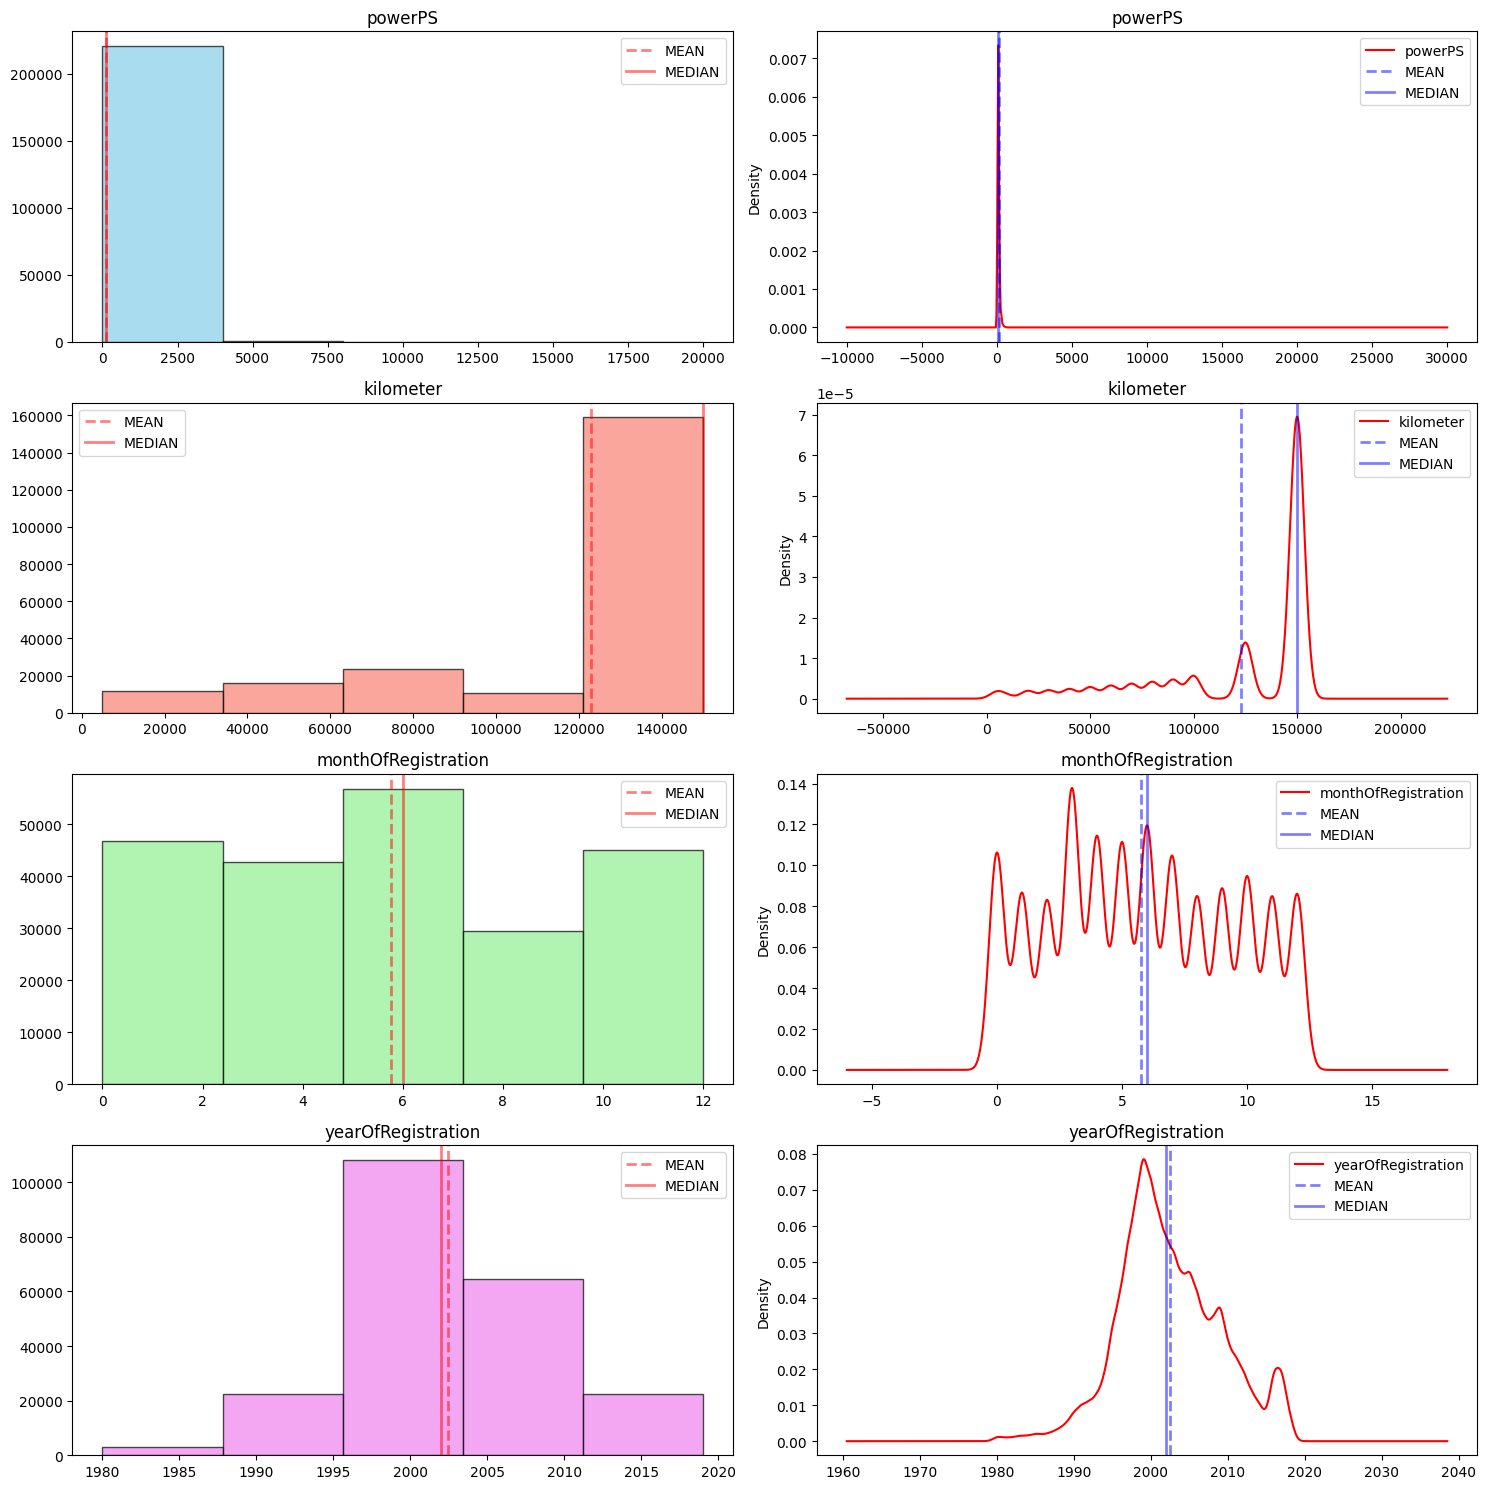

In [26]:
fig, axes= plt.subplots(4, 2, figsize=(15, 15))

# Define distinct colors for each plot
colors = ['skyblue', 'salmon', 'lightgreen', 'violet', 'gold', 'lightcoral']

for i, col in enumerate(numerical_cols):
    km_mean = df[col].mean()
    km_median = df[col].median()
    axes[i][0].hist(df[col].dropna(), bins=5, color=colors[i], edgecolor='black', alpha=0.7)
    axes[i][0].axvline(km_mean, color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
    axes[i][0].axvline(km_median, color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
    axes[i][0].legend()
    df[col].plot(kind='kde', ax=axes[i][1], xlabel='KM',  color='red')
    axes[i][1].axvline(km_mean, color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
    axes[i][1].axvline(km_median, color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
    axes[i][1].legend()

    axes[i][0].set_title(col)
    axes[i][1].set_title(col)


plt.tight_layout()
plt.show()


**Note:**

- None of the histograms, except for `yearOfRegistration`, follow a normal distribution. Therefore, applying standard parametric statistical methods may not be appropriate.
- `powerPS` shows a narrow range with low variation — this feature requires further investigation.
- `kilometer` is highly right-skewed, indicating that most vehicles have high mileage.


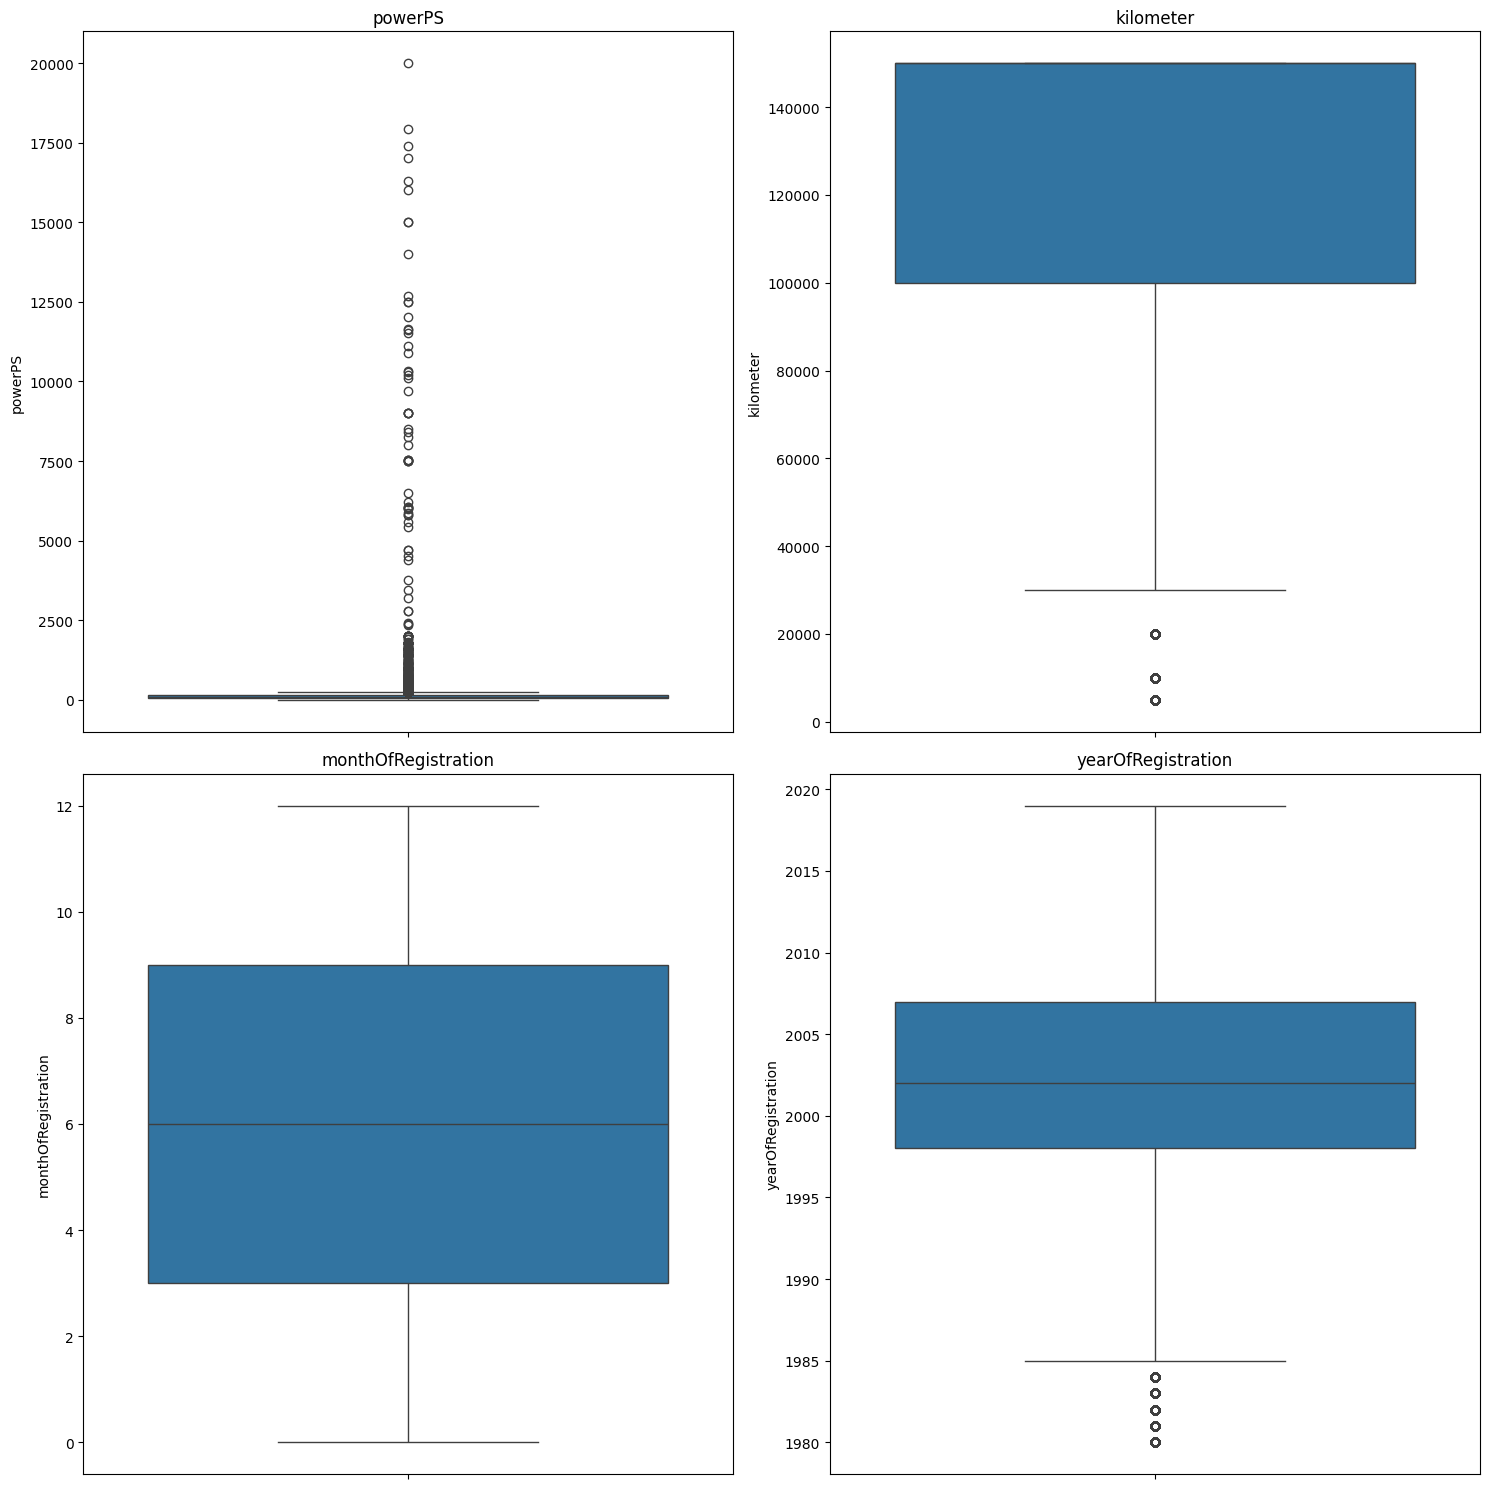

In [27]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
axes = ax.flatten()
for i,col in enumerate(numerical_cols):
  sns.boxplot(df[col],ax=axes[i])
  axes[i].set_title(col)
plt.tight_layout()
plt.show()

**Note:**

- `powerPS` contains a significant number of outliers that may affect model performance and should be handled appropriately.
- `kilometer` is right-skewed, with most entries concentrated at higher mileage levels.


In [28]:
%pip install colorama

Note: you may need to restart the kernel to use updated packages.


In [29]:
df.columns

Index(['name', 'price', 'abtest', 'vehicleType', 'yearOfRegistration',
       'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration',
       'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'postalCode'],
      dtype='object')

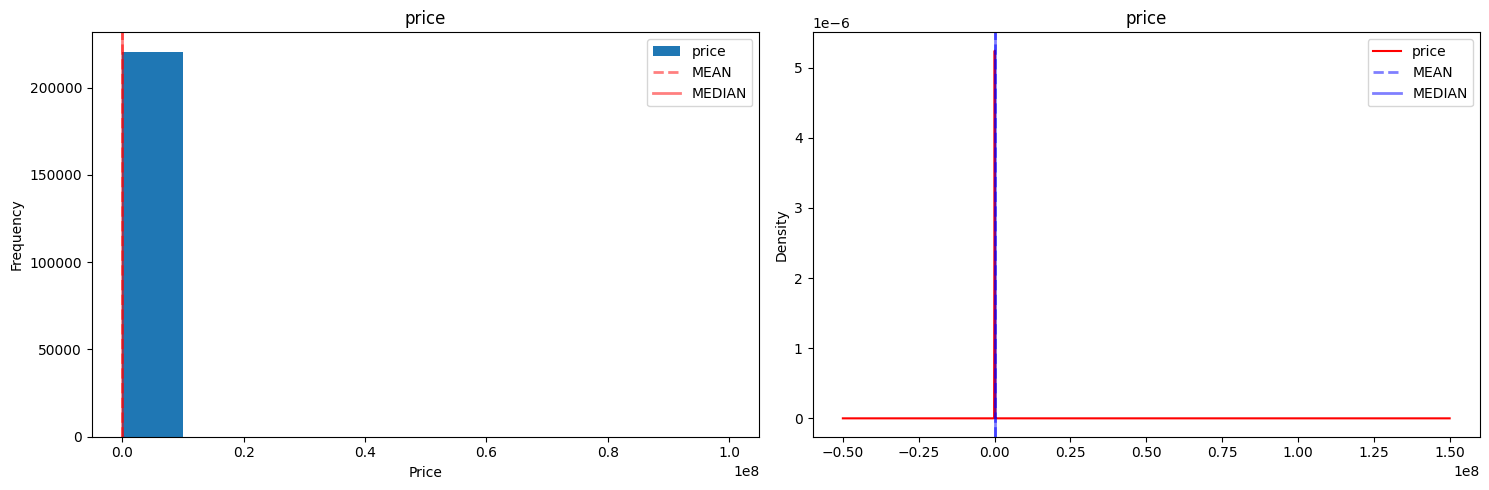

In [30]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes = axes.flatten()
col = 'price'
km_mean = df[col].mean()
km_median = df[col].median()
df[col].plot(kind='hist', bins=10, ax=axes[0], title='Histogram of Price in Range [200, 20K]', xlabel='Price')
axes[0].axvline(km_mean, color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0].axvline(km_median, color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0].legend()
df[col].plot(kind='kde', ax=axes[1], xlabel='KM',  color='red')
axes[1].axvline(km_mean, color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1].axvline(km_median, color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1].legend()

axes[0].set_title(col)
axes[1].set_title(col)


plt.tight_layout()
plt.show()

**Note:**

- The `price` range appears to be irregular or contains anomalies.
- To better understand the distribution, we will divide `price` into multiple ranges (bins) and analyze them separately.

In [31]:
from colorama import Fore, Back, Style

In [32]:
print(f"No. of cars with a price value higher than 20K: {Style.BRIGHT}{len(df[df['price'] > 20_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 30K: {Style.BRIGHT}{len(df[df['price'] > 30_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 40K: {Style.BRIGHT}{len(df[df['price'] > 40_000])}")
print(f"{Style.RESET_ALL}Mean of price: {Style.BRIGHT}{df['price'].mean():.2f}{Style.RESET_ALL}, Median of price: {Style.BRIGHT}{df['price'].median()}")
print(f"{Style.RESET_ALL}Min. price: {Style.BRIGHT}{df['price'].min()}{Style.RESET_ALL}, Max. price: {Style.BRIGHT}{df['price'].max()}")

No. of cars with a price value higher than 20K: 6928
No. of cars with a price value higher than 30K: 2712
No. of cars with a price value higher than 40K: 1506
Mean of price: 7742.11, Median of price: 2200.0
Min. price: 0, Max. price: 99999999


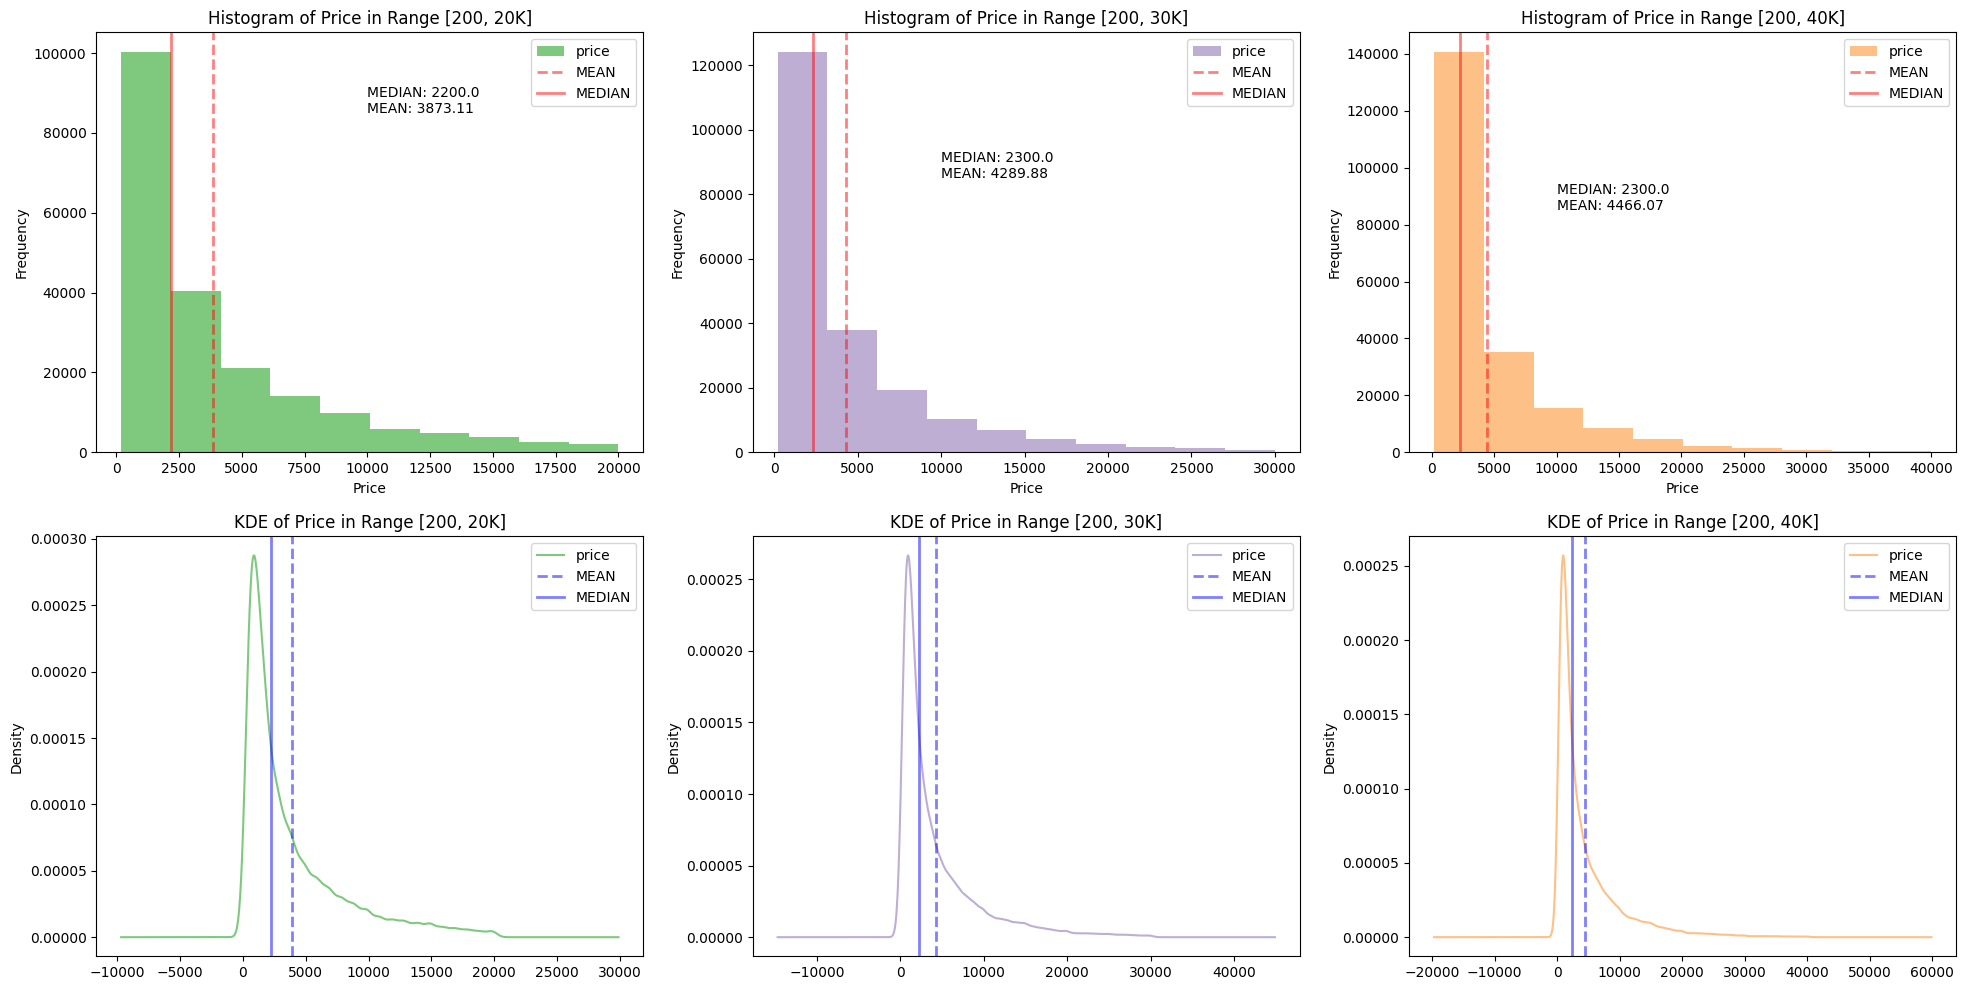

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

bins = 10

price_20 = df.loc[df['price'].between(200, 20_000), 'price']
price_30 = df.loc[df['price'].between(200, 30_000), 'price']
price_40 = df.loc[df['price'].between(200, 40_000), 'price']

price_20.plot(kind='hist', bins=bins, ax=axes[0,0], title='Histogram of Price in Range [200, 20K]', xlabel='Price', color=colors_5[0])
axes[0,0].axvline(price_20.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,0].axvline(price_20.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,0].legend()
txt = f'MEDIAN: {price_20.median()}\nMEAN: {price_20.mean():.2f}'
axes[0,0].text(10_000, 85_000, txt)

price_30.plot(kind='hist', bins=bins, ax=axes[0,1], title='Histogram of Price in Range [200, 30K]', xlabel='Price', color=colors_5[1])
axes[0,1].axvline(price_30.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,1].axvline(price_30.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,1].legend()
txt = f'MEDIAN: {price_30.median()}\nMEAN: {price_30.mean():.2f}'
axes[0,1].text(10_000, 85_000, txt)

price_40.plot(kind='hist', bins=bins, ax=axes[0,2], title='Histogram of Price in Range [200, 40K]', xlabel='Price', color=colors_5[2])
axes[0,2].axvline(price_40.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,2].axvline(price_40.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,2].legend()
txt = f'MEDIAN: {price_40.median()}\nMEAN: {price_40.mean():.2f}'
axes[0,2].text(10_000, 85_000, txt)

price_20.plot(kind='kde', ax=axes[1,0], title='KDE of Price in Range [200, 20K]', xlabel='Price',  color=colors_5[0])
axes[1,0].axvline(price_20.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,0].axvline(price_20.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,0].legend()

price_30.plot(kind='kde', ax=axes[1,1], title='KDE of Price in Range [200, 30K]', xlabel='Price',  color=colors_5[1])
axes[1,1].axvline(price_30.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,1].axvline(price_30.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,1].legend()

price_40.plot(kind='kde', ax=axes[1,2], title='KDE of Price in Range [200, 40K]', xlabel='Price',  color=colors_5[2])
axes[1,2].axvline(price_40.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,2].axvline(price_40.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,2].legend()
plt.show()

**Note:**

- The price range of **[200, 20,000]** appears to be the most meaningful.
- It effectively captures the majority of valid data while eliminating a large proportion of outliers present in extremely low or high price ranges.

In [34]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [35]:
# drop null values, to remove notrepairedDammaged NA values
df.dropna(inplace=True)
df = df[df['notRepairedDamage'] != 'NaN']

# Drop cars with unacceptable prices
df = df[df['price'].between(200, 20000)]

# Drop cars with extreme powerPS
df = df[(df['powerPS'] > 0) & (df['powerPS'] <= 1000)]

# Add the 'age' column
current_year = 2025
df['age'] = current_year - df['yearOfRegistration']

# Drop unnecessary columns and rows
df.drop(['postalCode', 'dateCreated', 'name', 'monthOfRegistration', 'yearOfRegistration'], axis=1, inplace=True)


In [36]:
# Categorical to Numerical
categorical_features = ['vehicleType', 'fuelType', 'brand', 'model', 'abtest', 'notRepairedDamage', 'gearbox']
le = LabelEncoder()

for categorical_feature in categorical_features:
    df[categorical_feature] = le.fit_transform(df[categorical_feature])

In [37]:
df.columns

Index(['price', 'abtest', 'vehicleType', 'gearbox', 'powerPS', 'model',
       'kilometer', 'fuelType', 'brand', 'notRepairedDamage', 'age'],
      dtype='object')

In [38]:
numerical_cols = ['price','powerPS', 'kilometer', 'age']

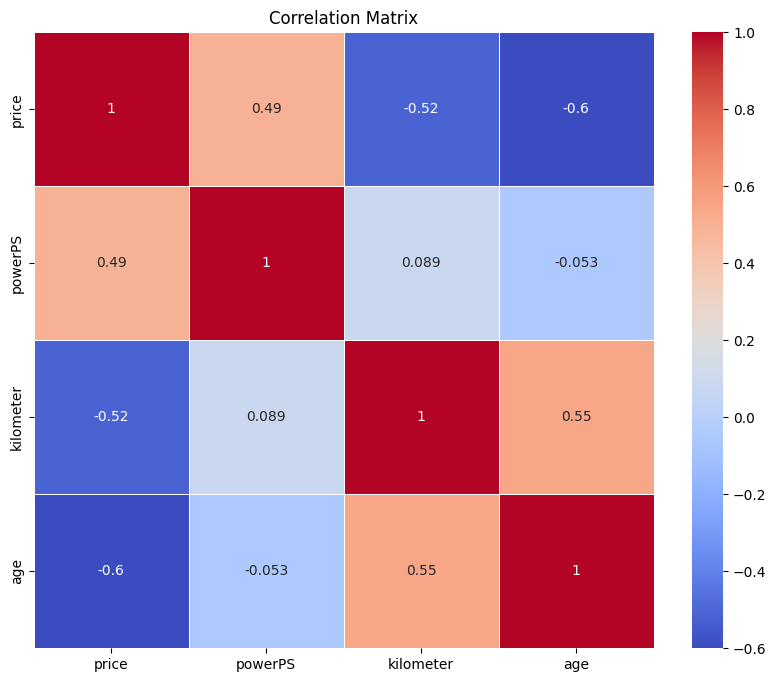

In [39]:
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Note:**

- There is a strong positive correlation between `powerPS` and `price`, indicating that vehicles with higher power tend to have higher prices.

In [40]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [41]:
features = df.drop(['price'], axis=1)
target = df['price']

scaler = StandardScaler()
numerical_features = ['kilometer', 'powerPS', 'age']
features[numerical_features] = scaler.fit_transform(features[numerical_features])

In [42]:
X_train, X_test,y_train, y_test = train_test_split(features, target, random_state=666, train_size=0.85)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=666, train_size=0.8235)

### ANN

In [43]:
epoch = 50
batch_size = 512
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_model.h5', monitor='val_mean_absolute_error', mode='min', verbose=1, save_best_only=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [44]:
model = Sequential()

# 1st Block
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', name='Dense_1'))
model.add(BatchNormalization(name='BatchNorm_1'))
model.add(Dropout(0.3, name='Dropout_1'))

# 2nd Block
model.add(Dense(64, activation='relu', name='Dense_2'))
model.add(BatchNormalization(name='BatchNorm_2'))
model.add(Dropout(0.3, name='Dropout_2'))

# 3rd Block
model.add(Dense(128, activation='relu', name='Dense_3'))
model.add(BatchNormalization(name='BatchNorm_3'))
model.add(Dropout(0.4, name='Dropout_3'))

# 4th Block
model.add(Dense(64, activation='relu', name='Dense_4'))
model.add(BatchNormalization(name='BatchNorm_4'))
model.add(Dropout(0.3, name='Dropout_4'))

# 5th Block
model.add(Dense(32, activation='relu', name='Dense_5'))
model.add(BatchNormalization(name='BatchNorm_5'))

# Output Layer
model.add(Dense(1, activation='linear', name='Predictor'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_1                     │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_3                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_4                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_5                     │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictor (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,433 (87.63 KB)

 Trainable params: 21,793 (85.13 KB)

 Non-trainable params: 640 (2.50 KB)

In [46]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epoch,
                    callbacks=[mc, lr_schedule, es])

Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37509056.0000 - mean_absolute_error: 4359.1694
Epoch 1: val_mean_absolute_error improved from inf to 4360.58203, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 37507804.0000 - mean_absolute_error: 4359.1279 - val_loss: 37279508.0000 - val_mean_absolute_error: 4360.5820 - learning_rate: 0.0010
Epoch 2/50
205/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37013560.0000 - mean_absolute_error: 4337.2588
Epoch 2: val_mean_absolute_error did not improve from 4360.58203
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37014380.0000 - mean_absolute_error: 4337.3853 - val_loss: 37223432.0000 - val_mean_absolute_error: 4364.4233 - learning_rate: 0.0010
Epoch 3/50
202/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37017400.0000 - mean_absolute_error: 4342.4668
Epoch 3: val_mean_absolute_error improved from 4360.58203 to 4350.26904, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37009612.0000 - mean_absolute_error: 4342.1079 - val_loss: 36986748.0000 - val_mean_absolute_error: 4350.2690 - learning_rate: 0.0010
Epoch 4/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36049416.0000 - mean_absolute_error: 4288.3936
Epoch 4: val_mean_absolute_error improved from 4350.26904 to 4303.84082, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36065096.0000 - mean_absolute_error: 4289.4712 - val_loss: 36425000.0000 - val_mean_absolute_error: 4303.8408 - learning_rate: 0.0010
Epoch 5/50
204/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35820832.0000 - mean_absolute_error: 4281.4253
Epoch 5: val_mean_absolute_error improved from 4303.84082 to 4279.26416, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35822760.0000 - mean_absolute_error: 4281.5479 - val_loss: 35947644.0000 - val_mean_absolute_error: 4279.2642 - learning_rate: 0.0010
Epoch 6/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35371928.0000 - mean_absolute_error: 4250.8516
Epoch 6: val_mean_absolute_error improved from 4279.26416 to 4263.17578, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35371604.0000 - mean_absolute_error: 4251.1660 - val_loss: 35304776.0000 - val_mean_absolute_error: 4263.1758 - learning_rate: 0.0010
Epoch 7/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34807244.0000 - mean_absolute_error: 4222.1973
Epoch 7: val_mean_absolute_error improved from 4263.17578 to 4243.39160, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34803540.0000 - mean_absolute_error: 4222.1978 - val_loss: 34805592.0000 - val_mean_absolute_error: 4243.3916 - learning_rate: 0.0010
Epoch 8/50
205/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34396956.0000 - mean_absolute_error: 4198.2407
Epoch 8: val_mean_absolute_error improved from 4243.39160 to 4201.55664, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34390124.0000 - mean_absolute_error: 4197.9478 - val_loss: 34296784.0000 - val_mean_absolute_error: 4201.5566 - learning_rate: 0.0010
Epoch 9/50
189/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34303840.0000 - mean_absolute_error: 4197.8638
Epoch 9: val_mean_absolute_error improved from 4201.55664 to 4148.65234, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34214696.0000 - mean_absolute_error: 4192.4927 - val_loss: 33228338.0000 - val_mean_absolute_error: 4148.6523 - learning_rate: 0.0010
Epoch 10/50
201/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32838332.0000 - mean_absolute_error: 4106.1172
Epoch 10: val_mean_absolute_error improved from 4148.65234 to 4120.18262, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32824392.0000 - mean_absolute_error: 4105.4902 - val_loss: 32651236.0000 - val_mean_absolute_error: 4120.1826 - learning_rate: 0.0010
Epoch 11/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31643262.0000 - mean_absolute_error: 4040.9888
Epoch 11: val_mean_absolute_error improved from 4120.18262 to 4090.36646, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31640730.0000 - mean_absolute_error: 4040.7671 - val_loss: 32229136.0000 - val_mean_absolute_error: 4090.3665 - learning_rate: 0.0010
Epoch 12/50
202/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31167010.0000 - mean_absolute_error: 4005.8821
Epoch 12: val_mean_absolute_error improved from 4090.36646 to 4002.79932, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31152302.0000 - mean_absolute_error: 4005.0852 - val_loss: 30712452.0000 - val_mean_absolute_error: 4002.7993 - learning_rate: 0.0010
Epoch 13/50
188/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30303212.0000 - mean_absolute_error: 3958.5420
Epoch 13: val_mean_absolute_error improved from 4002.79932 to 3982.91968, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30253436.0000 - mean_absolute_error: 3954.8579 - val_loss: 30466478.0000 - val_mean_absolute_error: 3982.9197 - learning_rate: 0.0010
Epoch 14/50
187/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28438518.0000 - mean_absolute_error: 3833.9749
Epoch 14: val_mean_absolute_error improved from 3982.91968 to 3879.94385, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 28478400.0000 - mean_absolute_error: 3836.6030 - val_loss: 29215432.0000 - val_mean_absolute_error: 3879.9438 - learning_rate: 0.0010
Epoch 15/50
200/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28224736.0000 - mean_absolute_error: 3820.0471
Epoch 15: val_mean_absolute_error improved from 3879.94385 to 3854.70654, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 28207368.0000 - mean_absolute_error: 3818.8335 - val_loss: 28824306.0000 - val_mean_absolute_error: 3854.7065 - learning_rate: 0.0010
Epoch 16/50
201/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26966224.0000 - mean_absolute_error: 3727.7197
Epoch 16: val_mean_absolute_error improved from 3854.70654 to 3785.29688, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26960666.0000 - mean_absolute_error: 3727.5479 - val_loss: 28033942.0000 - val_mean_absolute_error: 3785.2969 - learning_rate: 0.0010
Epoch 17/50
206/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25949176.0000 - mean_absolute_error: 3655.3684
Epoch 17: val_mean_absolute_error improved from 3785.29688 to 3683.15186, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25947186.0000 - mean_absolute_error: 3655.3247 - val_loss: 26011858.0000 - val_mean_absolute_error: 3683.1519 - learning_rate: 0.0010
Epoch 18/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25268564.0000 - mean_absolute_error: 3614.6255
Epoch 18: val_mean_absolute_error improved from 3683.15186 to 3608.09448, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25245652.0000 - mean_absolute_error: 3612.9160 - val_loss: 25288962.0000 - val_mean_absolute_error: 3608.0945 - learning_rate: 0.0010
Epoch 19/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24176508.0000 - mean_absolute_error: 3534.2957
Epoch 19: val_mean_absolute_error improved from 3608.09448 to 3589.15747, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24156896.0000 - mean_absolute_error: 3532.7900 - val_loss: 24794054.0000 - val_mean_absolute_error: 3589.1575 - learning_rate: 0.0010
Epoch 20/50
188/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22990226.0000 - mean_absolute_error: 3446.4727
Epoch 20: val_mean_absolute_error improved from 3589.15747 to 3481.79102, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22964264.0000 - mean_absolute_error: 3444.5015 - val_loss: 23396518.0000 - val_mean_absolute_error: 3481.7910 - learning_rate: 0.0010
Epoch 21/50
206/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21662580.0000 - mean_absolute_error: 3337.6145
Epoch 21: val_mean_absolute_error improved from 3481.79102 to 3448.41089, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21662214.0000 - mean_absolute_error: 3337.6604 - val_loss: 23073542.0000 - val_mean_absolute_error: 3448.4109 - learning_rate: 0.0010
Epoch 22/50
189/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21254444.0000 - mean_absolute_error: 3312.5396
Epoch 22: val_mean_absolute_error improved from 3448.41089 to 3367.31421, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21192234.0000 - mean_absolute_error: 3307.1892 - val_loss: 21678362.0000 - val_mean_absolute_error: 3367.3142 - learning_rate: 0.0010
Epoch 23/50
197/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20234406.0000 - mean_absolute_error: 3229.5376
Epoch 23: val_mean_absolute_error improved from 3367.31421 to 3272.02417, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20198722.0000 - mean_absolute_error: 3226.4663 - val_loss: 20711516.0000 - val_mean_absolute_error: 3272.0242 - learning_rate: 0.0010
Epoch 24/50
202/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18597680.0000 - mean_absolute_error: 3084.5374
Epoch 24: val_mean_absolute_error improved from 3272.02417 to 3219.06519, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18596344.0000 - mean_absolute_error: 3084.5935 - val_loss: 20471828.0000 - val_mean_absolute_error: 3219.0652 - learning_rate: 0.0010
Epoch 25/50
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17875912.0000 - mean_absolute_error: 3030.6006
Epoch 25: val_mean_absolute_error improved from 3219.06519 to 3064.19409, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 17872832.0000 - mean_absolute_error: 3030.2988 - val_loss: 18045848.0000 - val_mean_absolute_error: 3064.1941 - learning_rate: 0.0010
Epoch 26/50
190/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16760248.0000 - mean_absolute_error: 2935.9810
Epoch 26: val_mean_absolute_error improved from 3064.19409 to 2984.13965, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16747577.0000 - mean_absolute_error: 2934.0947 - val_loss: 17663992.0000 - val_mean_absolute_error: 2984.1396 - learning_rate: 0.0010
Epoch 27/50
204/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15985067.0000 - mean_absolute_error: 2847.6997
Epoch 27: val_mean_absolute_error improved from 2984.13965 to 2933.29224, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15976014.0000 - mean_absolute_error: 2847.0376 - val_loss: 16976848.0000 - val_mean_absolute_error: 2933.2922 - learning_rate: 0.0010
Epoch 28/50
198/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15088677.0000 - mean_absolute_error: 2768.1541
Epoch 28: val_mean_absolute_error improved from 2933.29224 to 2777.43701, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15066318.0000 - mean_absolute_error: 2766.1084 - val_loss: 15045215.0000 - val_mean_absolute_error: 2777.4370 - learning_rate: 0.0010
Epoch 29/50
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13694847.0000 - mean_absolute_error: 2626.9688
Epoch 29: val_mean_absolute_error did not improve from 2777.43701
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13695402.0000 - mean_absolute_error: 2627.0730 - val_loss: 15967128.0000 - val_mean_absolute_error: 2885.2207 - learning_rate: 0.0010
Epoch 30/50
206/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12960082.0000 - mean_absolute_error: 2550.0371
Epoch 30: val_mean_absolute_error improved from 2777.43701 to 2675.91187, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12958540.0000 - mean_absolute_error: 2549.9575 - val_loss: 14143694.0000 - val_mean_absolute_error: 2675.9119 - learning_rate: 0.0010
Epoch 31/50
205/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12188724.0000 - mean_absolute_error: 2476.4331
Epoch 31: val_mean_absolute_error improved from 2675.91187 to 2566.70605, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12185050.0000 - mean_absolute_error: 2476.0098 - val_loss: 13272175.0000 - val_mean_absolute_error: 2566.7061 - learning_rate: 0.0010
Epoch 32/50
198/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11385380.0000 - mean_absolute_error: 2388.0347
Epoch 32: val_mean_absolute_error improved from 2566.70605 to 2424.19653, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11374609.0000 - mean_absolute_error: 2386.6709 - val_loss: 12142561.0000 - val_mean_absolute_error: 2424.1965 - learning_rate: 0.0010
Epoch 33/50
203/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10694998.0000 - mean_absolute_error: 2306.9712
Epoch 33: val_mean_absolute_error improved from 2424.19653 to 2317.82153, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10687142.0000 - mean_absolute_error: 2305.9690 - val_loss: 11350478.0000 - val_mean_absolute_error: 2317.8215 - learning_rate: 0.0010
Epoch 34/50
191/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9778315.0000 - mean_absolute_error: 2194.9526
Epoch 34: val_mean_absolute_error did not improve from 2317.82153
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9772926.0000 - mean_absolute_error: 2194.3713 - val_loss: 11366408.0000 - val_mean_absolute_error: 2323.6514 - learning_rate: 0.0010
Epoch 35/50
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9173963.0000 - mean_absolute_error: 2118.1931
Epoch 35: val_mean_absolute_error improved from 2317.82153 to 2176.46533, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9172121.0000 - mean_absolute_error: 2117.9568 - val_loss: 9815430.0000 - val_mean_absolute_error: 2176.4653 - learning_rate: 0.0010
Epoch 36/50
206/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8411728.0000 - mean_absolute_error: 2024.1614
Epoch 36: val_mean_absolute_error improved from 2176.46533 to 2089.10376, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8410326.0000 - mean_absolute_error: 2023.9093 - val_loss: 9560717.0000 - val_mean_absolute_error: 2089.1038 - learning_rate: 0.0010
Epoch 37/50
200/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7912817.5000 - mean_absolute_error: 1954.3984
Epoch 37: val_mean_absolute_error improved from 2089.10376 to 1922.58228, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7904043.0000 - mean_absolute_error: 1953.1018 - val_loss: 8383463.0000 - val_mean_absolute_error: 1922.5823 - learning_rate: 0.0010
Epoch 38/50
189/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7304127.5000 - mean_absolute_error: 1865.2405
Epoch 38: val_mean_absolute_error improved from 1922.58228 to 1885.77844, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7290079.5000 - mean_absolute_error: 1863.3344 - val_loss: 8134774.5000 - val_mean_absolute_error: 1885.7784 - learning_rate: 0.0010
Epoch 39/50
198/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6889517.5000 - mean_absolute_error: 1806.2478
Epoch 39: val_mean_absolute_error did not improve from 1885.77844
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6875494.0000 - mean_absolute_error: 1804.0721 - val_loss: 8108451.5000 - val_mean_absolute_error: 1932.1388 - learning_rate: 0.0010
Epoch 40/50
201/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6341887.5000 - mean_absolute_error: 1728.0994
Epoch 40: val_mean_absolute_error improved from 1885.77844 to 1793.83142, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6333736.5000 - mean_absolute_error: 1726.6705 - val_loss: 6887823.5000 - val_mean_absolute_error: 1793.8314 - learning_rate: 0.0010
Epoch 41/50
200/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5699780.0000 - mean_absolute_error: 1622.4688
Epoch 41: val_mean_absolute_error improved from 1793.83142 to 1788.82556, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5699579.0000 - mean_absolute_error: 1622.4000 - val_loss: 7208525.5000 - val_mean_absolute_error: 1788.8256 - learning_rate: 0.0010
Epoch 42/50
187/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5461831.0000 - mean_absolute_error: 1580.8665
Epoch 42: val_mean_absolute_error improved from 1788.82556 to 1465.16431, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5447517.5000 - mean_absolute_error: 1578.8168 - val_loss: 5401358.0000 - val_mean_absolute_error: 1465.1643 - learning_rate: 0.0010
Epoch 43/50
201/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5022552.5000 - mean_absolute_error: 1503.9150
Epoch 43: val_mean_absolute_error did not improve from 1465.16431
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5021575.0000 - mean_absolute_error: 1503.8743 - val_loss: 5210974.5000 - val_mean_absolute_error: 1512.7939 - learning_rate: 0.0010
Epoch 44/50
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4687755.5000 - mean_absolute_error: 1448.6047
Epoch 44: val_mean_absolute_error did not improve from 1465.16431
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4687687.0000 - mean_absolute_error: 1448.6001 - val_loss: 5631544.0000 - val_mean_absolute_error: 1532.6859 - learning_rate: 0.0010
Epoch 45/50
200/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4410808.0000 - mean_absolute_error: 1403.2902
Epoc

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4410780.0000 - mean_absolute_error: 1403.1257 - val_loss: 4863050.5000 - val_mean_absolute_error: 1425.4626 - learning_rate: 0.0010
Epoch 46/50
205/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4216862.0000 - mean_absolute_error: 1365.4365
Epoch 46: val_mean_absolute_error improved from 1425.46265 to 1395.12500, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4216577.5000 - mean_absolute_error: 1365.3204 - val_loss: 4603462.0000 - val_mean_absolute_error: 1395.1250 - learning_rate: 0.0010
Epoch 47/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4093462.0000 - mean_absolute_error: 1342.5406
Epoch 47: val_mean_absolute_error improved from 1395.12500 to 1333.89172, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4090022.0000 - mean_absolute_error: 1341.5448 - val_loss: 4569430.0000 - val_mean_absolute_error: 1333.8917 - learning_rate: 0.0010
Epoch 48/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3814650.7500 - mean_absolute_error: 1287.1724
Epoch 48: val_mean_absolute_error improved from 1333.89172 to 1281.59558, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3815537.7500 - mean_absolute_error: 1287.1206 - val_loss: 4170648.0000 - val_mean_absolute_error: 1281.5956 - learning_rate: 0.0010
Epoch 49/50
202/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3738649.5000 - mean_absolute_error: 1264.4862
Epoch 49: val_mean_absolute_error did not improve from 1281.59558
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3738502.0000 - mean_absolute_error: 1264.3840 - val_loss: 4576218.0000 - val_mean_absolute_error: 1327.6984 - learning_rate: 0.0010
Epoch 50/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3636582.5000 - mean_absolute_error: 1240.7623
Epoch 50: val_mean_absolute_error improved from 1281.59558 to 1149.22559, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3636542.5000 - mean_absolute_error: 1240.6772 - val_loss: 3436618.0000 - val_mean_absolute_error: 1149.2256 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.


In [47]:
dnn_eval = model.evaluate(X_test, y_test)
dnn_preds = model.predict(X_test)

print(f"{Fore.BLUE}DNN - Test set\n\nMSE: {Fore.RED}{dnn_eval[0]}\n{Fore.BLUE}MAE: {Fore.RED}{dnn_eval[1]:.2f}")
print(f"{Fore.BLUE}R2-Score: {Fore.RED}{r2_score(y_test, dnn_preds):.3f}")

713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 3438974.5000 - mean_absolute_error: 1146.0293
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
DNN - Test set

MSE: 3416829.5
MAE: 1144.97
R2-Score: 0.813


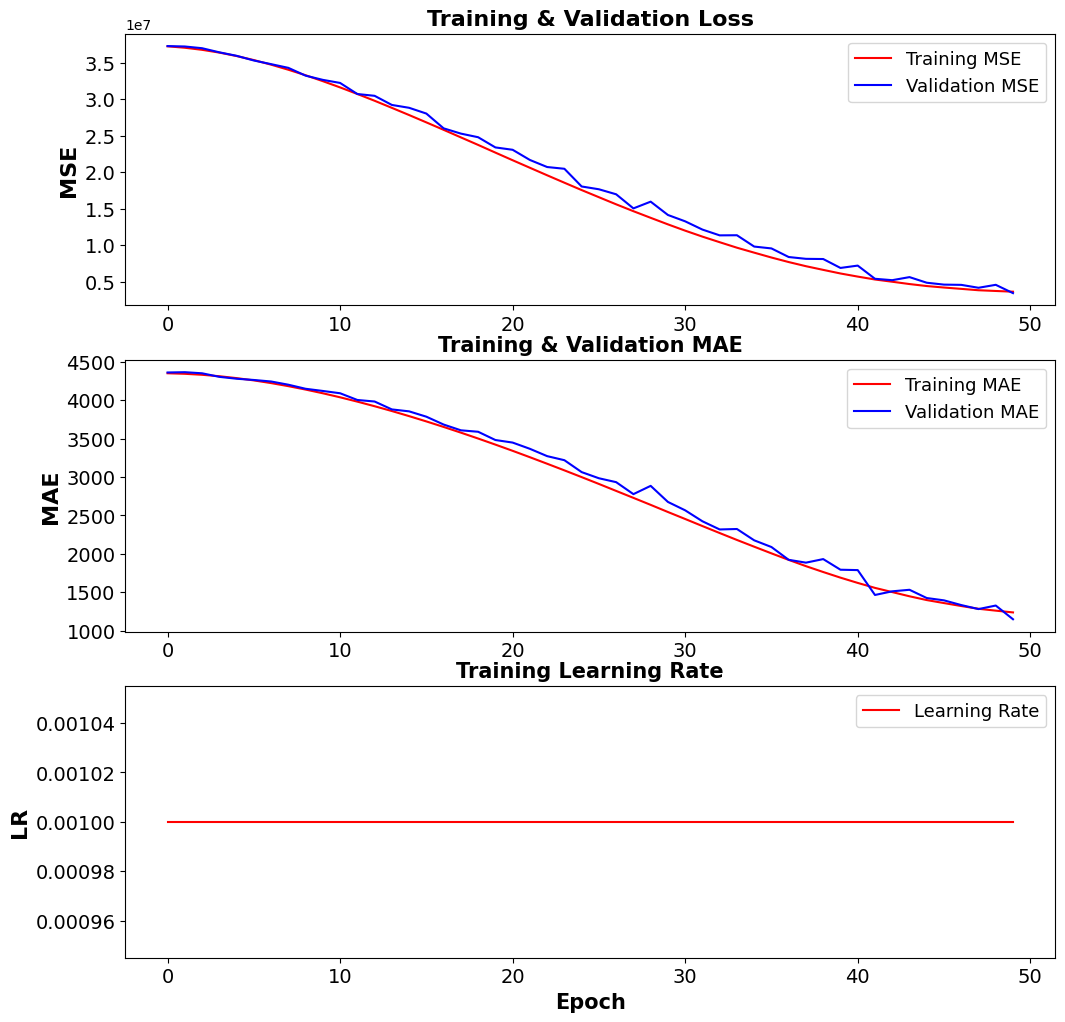

In [48]:
lr = history.history['learning_rate']
loss = history.history['loss']
val_loss = history.history['val_loss']
t_mae = history.history['mean_absolute_error']
v_mae = history.history['val_mean_absolute_error']

plt.figure(figsize=(12, 12))

# MSE
plt.subplot(3, 1, 1)
plt.plot(loss, label='Training MSE', color='r')
plt.plot(val_loss, label='Validation MSE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('MSE', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=16, weight='bold')

# MAE
plt.subplot(3, 1, 2)
plt.plot(t_mae, label='Training MAE', color='r')
plt.plot(v_mae, label='Validation MAE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.ylabel('MAE', fontsize=16, weight='bold')
plt.title('Training & Validation MAE', fontsize=15, weight='bold')

# Learning Rate
plt.subplot(3, 1, 3)
plt.plot(lr, label='Learning Rate', color='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('LR', fontsize=16, weight='bold')
plt.title('Training Learning Rate', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [49]:
import random

In [50]:
preds = dnn_preds.reshape(-1)

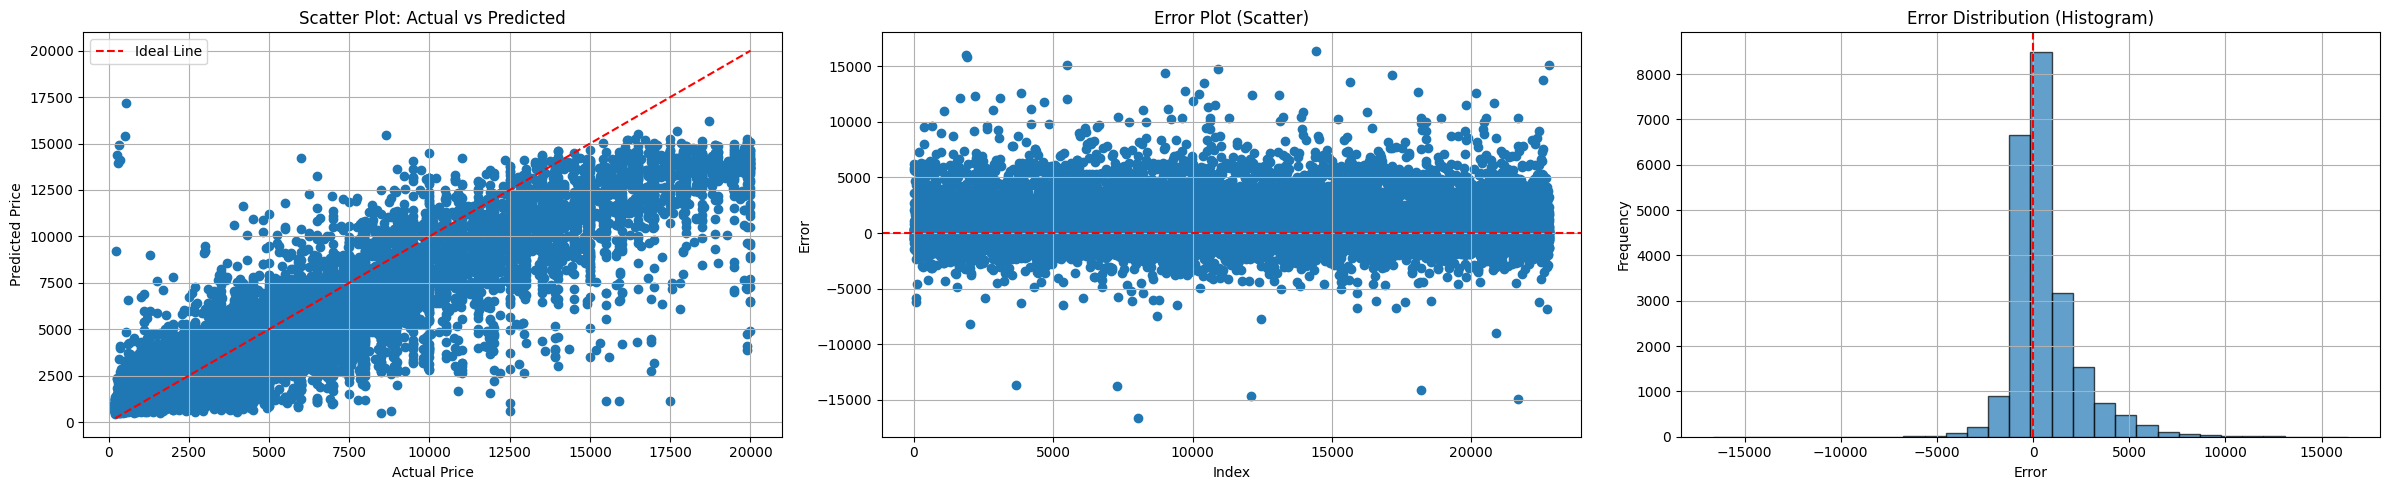

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(24, 5))  

# 1. Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, preds)
# Add reference line (ideal predictions line)
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Line')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Scatter Plot: Actual vs Predicted')
axes[0].legend()
axes[0].grid(True)

# 2. Error plot: Scatter instead of line
error = y_test - preds
axes[1].scatter(range(len(error)), error)
axes[1].axhline(0, color='red', linestyle='--') 
axes[1].set_title('Error Plot (Scatter)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Error')
axes[1].grid(True)

# 3. Error distribution plot
axes[2].hist(error, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='red', linestyle='--') 
axes[2].set_title('Error Distribution (Histogram)')
axes[2].set_xlabel('Error')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

# Layout
plt.tight_layout()
plt.show()


In [52]:
step = np.random.randint(1, 101)
for _ in range(10):
    print(y_test.values[step] - dnn_preds[step])
    step = np.random.randint(1, 101)

[-516.80761719]
[4346.10693359]
[23.10546875]
[214.83380127]
[459.28027344]
[1097.08496094]
[2351.83496094]
[2058.7421875]
[2351.83496094]
[-947.40234375]


**Note:**

- The model's R2 score is **0.824**, which is good but lower than expected. We will explore other traditional models to improve performance.
- The difference between actual and predicted prices is relatively large, indicating room for improvement.
- In most cases, the predicted price is lower than the actual price.
- The error distribution appears to be normal, suggesting the model has fit the data reasonably well.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=0.2, random_state=15)
print(f"Train Shape: {X_train.shape}\nTest Shape: {X_test.shape}")

Train Shape: (121611, 10)
Test Shape: (30403, 10)


In [54]:
scores_metric = {"R2-Score":make_scorer(r2_score),
                 "MAE":make_scorer(mean_absolute_error),
                 "MSE":make_scorer(mean_squared_error)}

In [55]:
def score_vis(score):

    names = ['Random Forest','AdaBoost', 'XGBoost', 'KNN']

    plt.rcParams['figure.figsize']=15,6
    ax = sns.barplot(x=names, y=score, palette = "plasma", saturation =2.0)

    plt.xlabel('Model', fontsize = 20 )
    plt.ylabel('R2-Score(%)', fontsize = 20)
    plt.title('Model Performance Comparison - Test set', fontsize = 20)
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)

    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy()
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize='x-large')

    plt.show()

In [56]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

In [57]:
def trainer(X_train, y_train, X_test, y_test):
    models = [['Random Forest', RandomForestRegressor(n_estimators=124)],
             ['AdaBoost', AdaBoostRegressor(loss='square', n_estimators=1000)],
             ['XGBoost', XGBRegressor(tree_method='hist', n_estimators=1000)],
             ['KNN', KNeighborsRegressor(weights='distance')]]

    scores = []

    print(Back.RED + Fore.BLACK + Style.BRIGHT + '⁜⁜ STARTING THE PROCESS... ⁜⁜\n\n')
    print(Back.RESET)

    for model_name, model in models:

        print(Fore.LIGHTRED_EX + 'Cross validating the ' + model_name + ' model...\n')
        model = model
        result = cross_validate(model, X_train, y_train, cv=5, verbose=1, scoring=scores_metric)

        for key, value in result.items():
            print(f"{Fore.BLUE}{key}: {Fore.RED}{np.mean(value):.3f} {Fore.BLUE}+- {Fore.RED}{np.std(value):.3f}")

        print(Fore.LIGHTGREEN_EX + '\nTraining...')
        model.fit(X_train, y_train)

        print(Fore.LIGHTGREEN_EX + 'Predicting...\n')
        pred = model.predict(X_test)

        scores.append(r2_score(y_test, pred))
        print(f"{Fore.BLUE}{model_name} Test R2-Score: {Fore.RED}{r2_score(y_test, pred):.3f}")
        print(f"{Fore.BLUE}{model_name} Test MAE:      {Fore.RED}{mean_absolute_error(y_test, pred):.3f}")

        print('\n' + Fore.BLACK + Back.WHITE + '⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜\n' + Back.RESET)

    print('\n\n\n' + Back.RED + Fore.BLACK + Style.BRIGHT + '⁜⁜ PROCESS COMPLETED! ⁜⁜')

    return scores

In [58]:
scores = trainer(X_train, y_train, X_test, y_test)

⁜⁜ STARTING THE PROCESS... ⁜⁜



Cross validating the Random Forest model...

fit_time: 17.855 +- 0.265
score_time: 0.810 +- 0.094
test_R2-Score: 0.902 +- 0.003
test_MAE: 821.035 +- 7.609
test_MSE: 1791763.827 +- 62500.468

Training...
Predicting...

Random Forest Test R2-Score: 0.905
Random Forest Test MAE:      807.823

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the AdaBoost model...

fit_time: 31.051 +- 6.289
score_time: 1.774 +- 0.060
test_R2-Score: -1.511 +- 0.040
test_MAE: 6302.262 +- 61.787
test_MSE: 46000691.977 +- 1005154.146

Training...
Predicting...

AdaBoost Test R2-Score: -1.580
AdaBoost Test MAE:      6430.554

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the XGBoost model...

fit_time: 1.659 +- 0.102
score_time: 0.056 +- 0.002
test_R2-Score: 0.909 +- 0.002
test_MAE: 782.117 +- 5.965
test_MSE: 1668315.900 +- 43899.006

Training...
Predicting...

XGBoost Test R2-Score: 0.913
XGBoost Test MAE:      767.740

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cro

In [59]:
scores

[0.9045899337190917,
 -1.580032334231376,
 0.9134374260902405,
 0.8830205802869702]

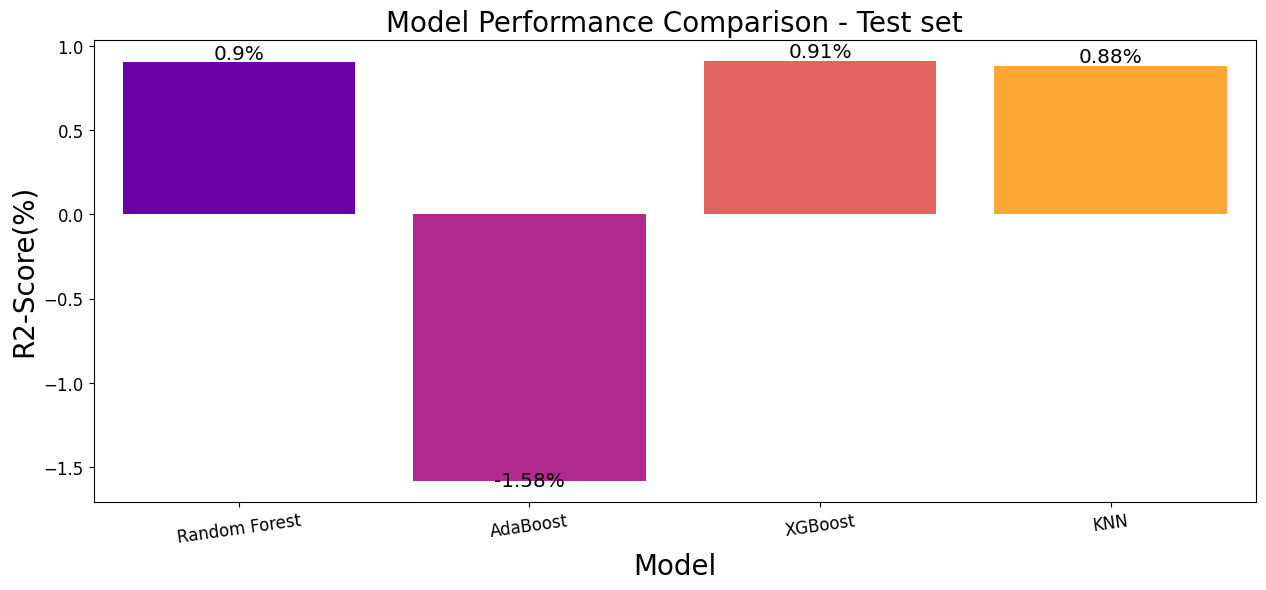

In [60]:
score_vis(scores)

In [61]:
xgbr_model = XGBRegressor(tree_method='hist', n_estimators=1000)
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [62]:
xgbr_pred = xgbr_model.predict(X_test, output_margin=True)
explainer = shap.TreeExplainer(xgbr_model)
shap_values = explainer.shap_values(X_test)
np.abs(shap_values.sum(1) + explainer.expected_value - xgbr_pred).max()

np.float32(0.0546875)

SHAP - XGBoost


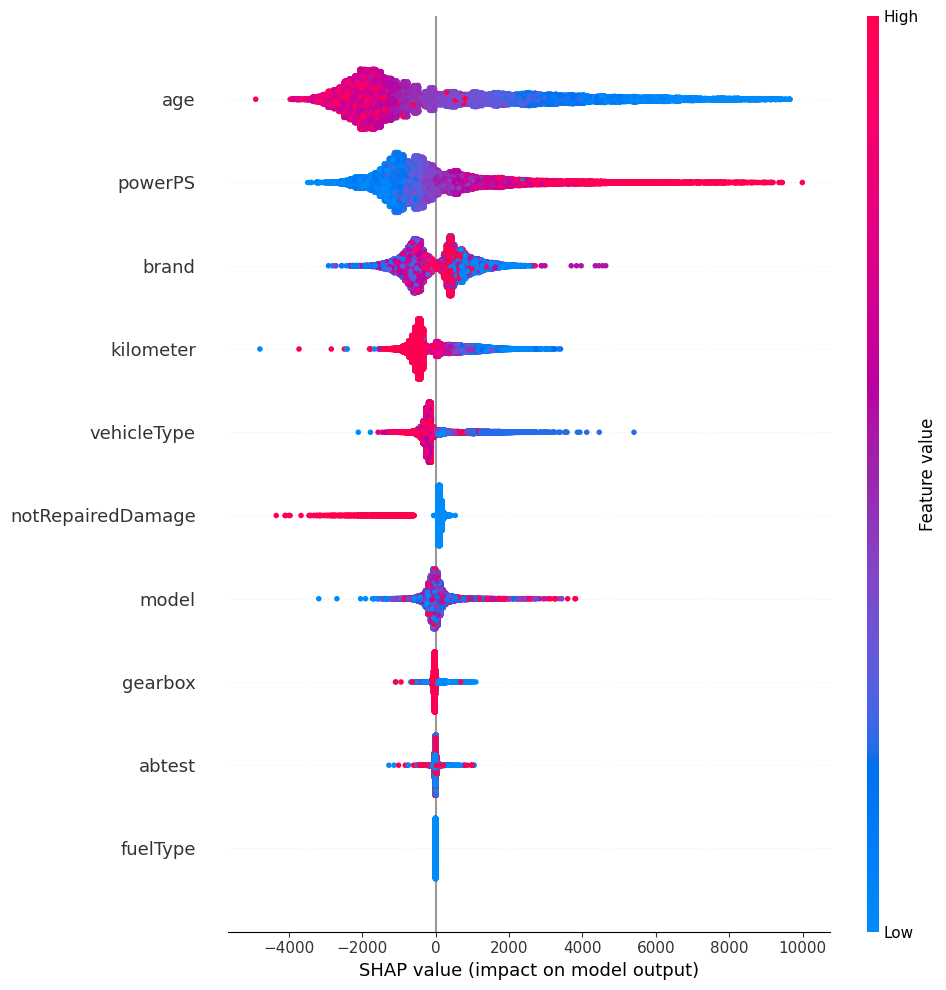

In [63]:
features_list = ['abtest','vehicleType','gearbox','powerPS','model','kilometer','fuelType','brand','notRepairedDamage','age']
print(Fore.BLUE + 'SHAP - XGBoost')
shap.summary_plot(shap_values=shap_values, features=X_test, feature_names=features_list, plot_size=(10, 10))

### Lets use our top 3 models and do ensemble learning

In [64]:
rfr_model = RandomForestRegressor(n_estimators=124)
xbr_model = XGBRegressor(tree_method='hist', n_estimators=1000)
knr_model = KNeighborsRegressor(weights='distance')

Weighted average, as our model accuracies were 0.91, 0.91 and 0.88 for random forrest, XGBoost and KNN.

Weights for weighted average will be

$$\frac{[0.91,0.91,0.88]}{\Sigma \ [0.91,0.91,0.88]} = [0.34, 0.34, 0.32]$$

In [65]:
print('Fitting the Random Forest model...\n')
rfr_model.fit(X_train, y_train)

print('Fitting the XGBRegressor model...\n')
xbr_model.fit(X_train, y_train)

print('Fitting the KNeighborsRegressor model...\n')
knr_model.fit(X_train, y_train)

Fitting the Random Forest model...

Fitting the XGBRegressor model...

Fitting the KNeighborsRegressor model...



KNeighborsRegressor(weights='distance')

In [66]:
rfr_pred = rfr_model.predict(X_test)
xbr_pred = xbr_model.predict(X_test)
knr_pred = knr_model.predict(X_test)

In [67]:
pred_final_w = np.round(0.34*rfr_pred + 0.34*xbr_pred + 0.32*knr_pred)

In [68]:
print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Weighted Averaging Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, pred_final_w):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, pred_final_w):.3f}")

Weighted Averaging Performance
Test R2-Score: 0.914
Test MAE:      767.652


## Stacking

In [69]:
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor

In [70]:
estimators = [ ('rfr', rfr_model),('xbr', xbr_model),  ('knr', knr_model)]

In [71]:
final_estimator = GradientBoostingRegressor(random_state=666)

stacking_model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

stacking_model.fit(X_train, y_train)

stacking_pred = stacking_model.predict(X_test)

In [72]:
print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Stacking Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, stacking_pred):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, stacking_pred):.3f}")

Stacking Performance
Test R2-Score: 0.917
Test MAE:      758.076
